<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

#  Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant R. L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes : régression [linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou   [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Industrialisaiton avec le package `caret` et itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision.

**Avertissement** 

* Ce tutoriel est découpé en 5 séances / épisodes de travaux dirigés syncronisées avec le cours d'apprentissage machine. 
* Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.
* Ce calepin est complété par celui en Python (à faire _après_, ou en parallèle) afin de comparer les performances respectives des deux environnements. 

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger (`corrplot, FactoMineR, glmnet, ROCR, mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab`). 

Python (consulter le [calepin](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) conduit à des résultats comparables mais moins complets pour leur interprétation. En particulier, l'absence du type *DataFrame* dans la librairie scikit-learn n'autorise pas une sélection fine des variables dans les modèles statistiques usuels. En revanche, l'exécution de la validation croisée Monte Carlo est plus rapide en python.

# <FONT COLOR="Red">Épisode 1</font>

## Prise en charge des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [2]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- "http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Vérification du contenu
summary(ozone)

      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [3]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

## Exploration élémentaire

Remarquer le type des variables. Il est nécessaire d'en étudier la distribution. Noter la symétrie ou non de celles-ci .

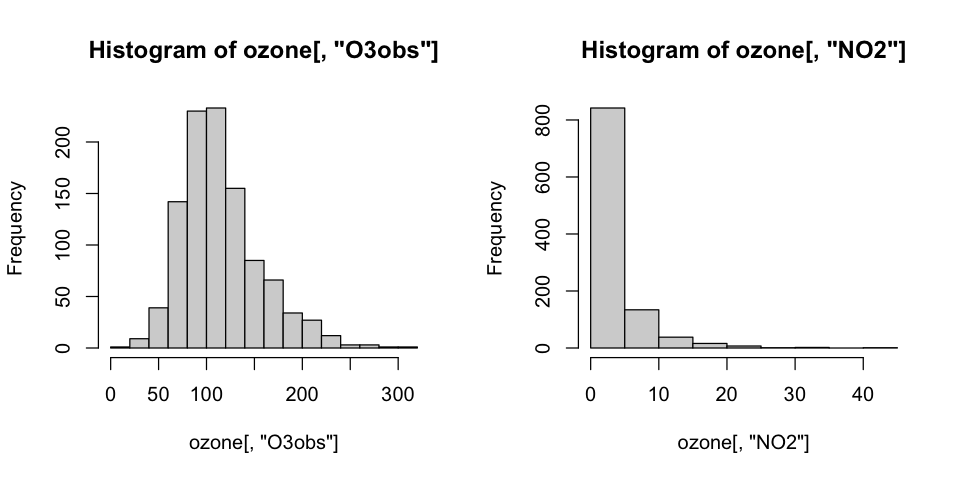

In [4]:
par(mfrow = c(1, 2))
options(repr.plot.width = 8, repr.plot.height = 4)
hist(ozone[, "O3obs"])
hist(ozone[, "NO2"])

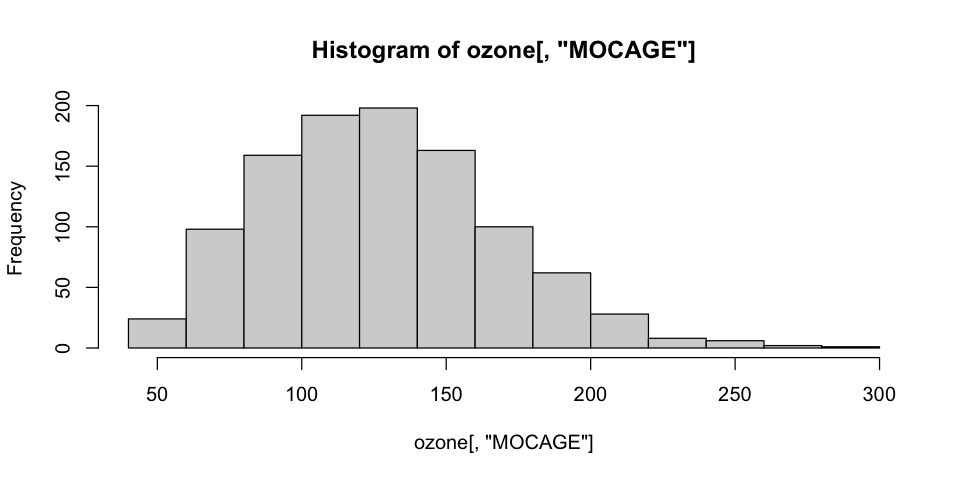

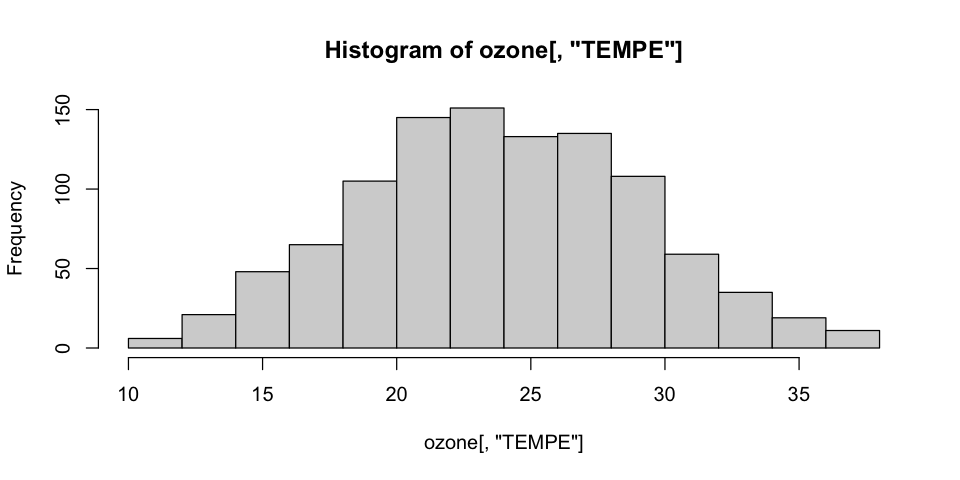

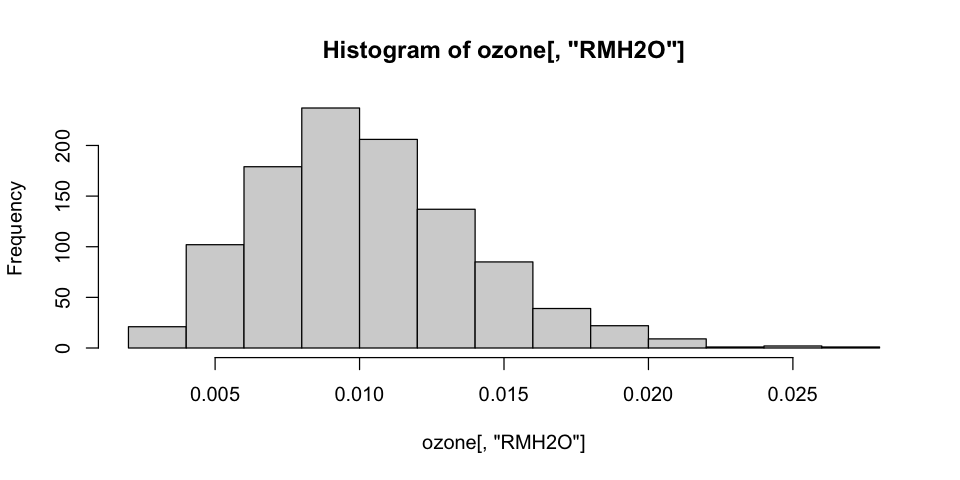

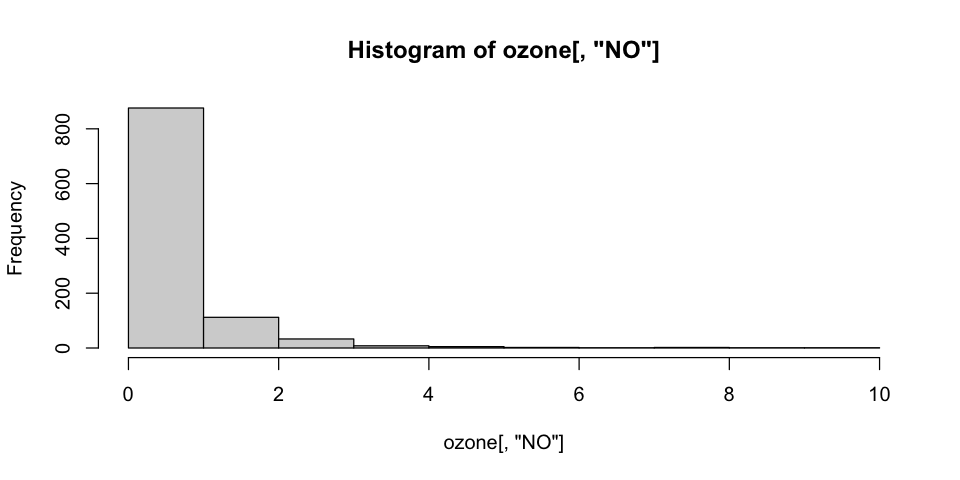

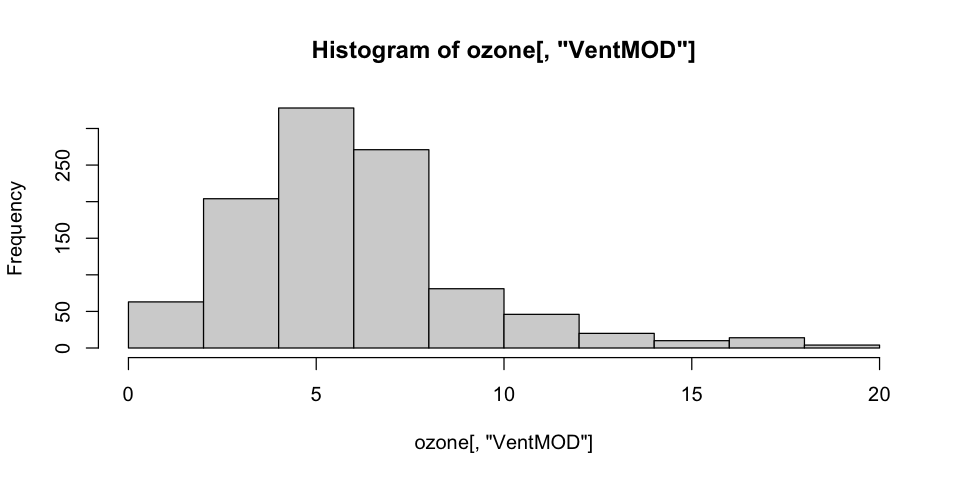

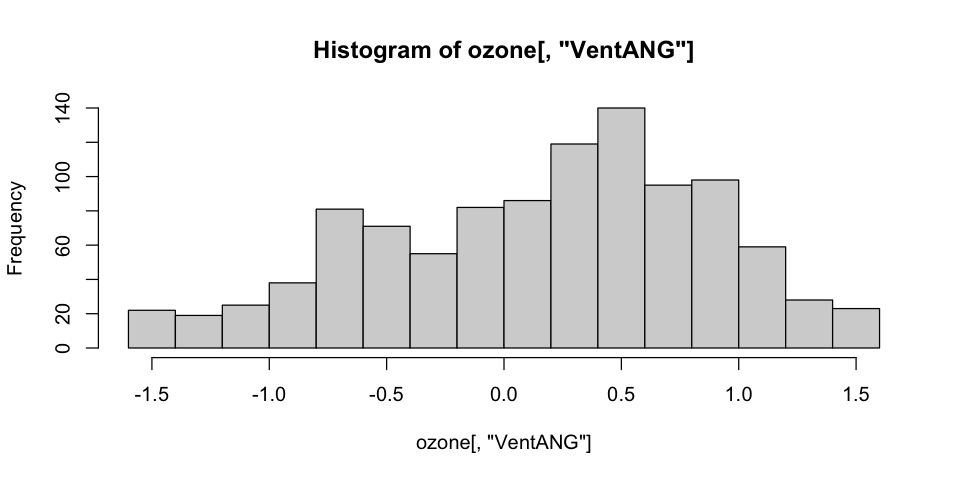

In [5]:
# Même chose pour les autres variables
 hist(ozone[,"MOCAGE"]);hist(ozone[,"TEMPE"]);hist(ozone[,"RMH2O"])
#
hist(ozone[,"NO"]);hist(ozone[,"VentMOD"]);hist(ozone[,"VentANG"])

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), par pour toutes (arbres).

In [6]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

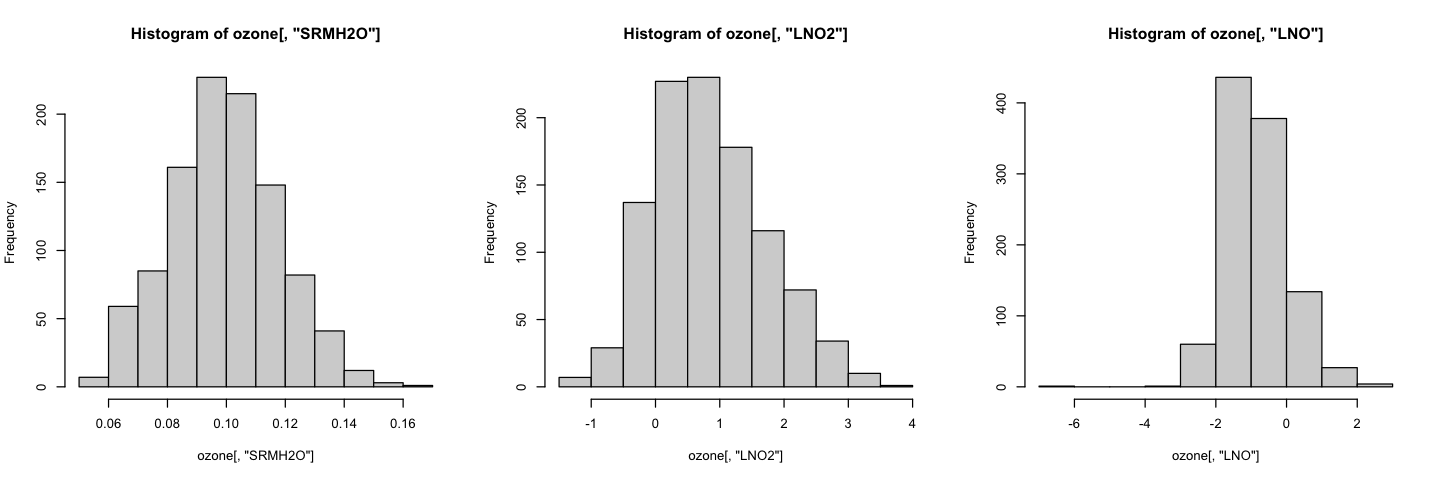

In [7]:
par(mfrow = c(1, 3))
options(repr.plot.width = 12, repr.plot.height = 4)
hist(ozone[, "SRMH2O"])
hist(ozone[, "LNO2"])
hist(ozone[, "LNO"])

Vérifier l'opportunité de ces transformations puis retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.


In [8]:
ozone <- ozone[, c(1:4, 8:13)]
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

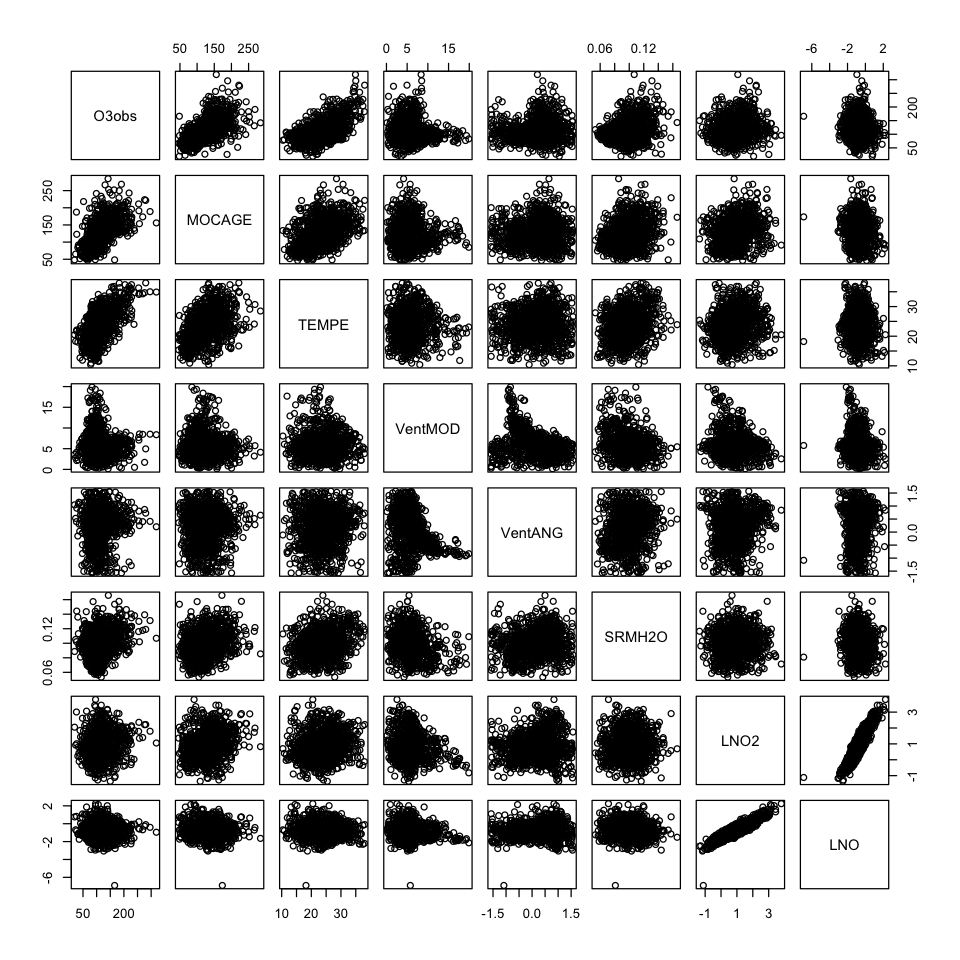

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
pairs(ozone[, c(2:4, 6:10)])

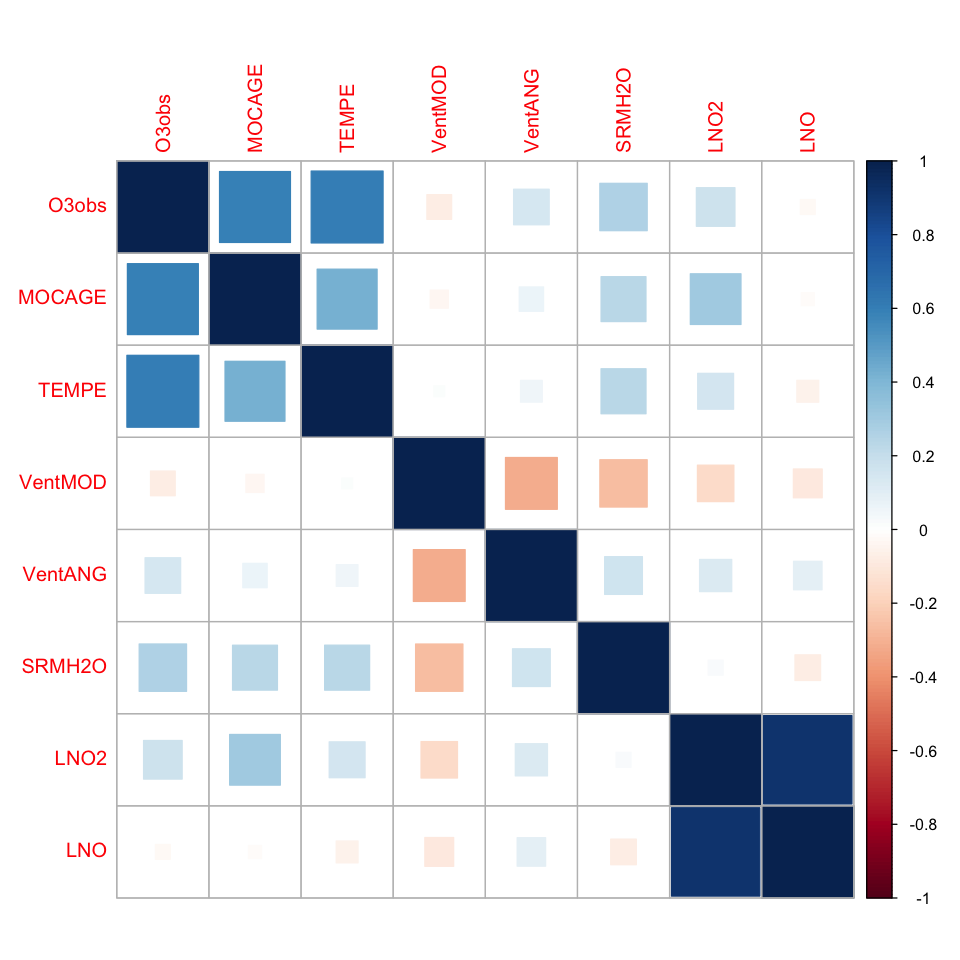

In [10]:
#install.packages("corrplot")

library(corrplot)
M<-cor(ozone[, c(2:4, 6:10)])
corrplot(M, method="square")


**Q** Que dire sur les relations des varibles 2 à 2 ?

**R**: Les variables semblent plutôt linéairement indépendantes sauf pour LNO et LNO2 qui sont très clairement corrélées linéairement.

**Q** Compléter en visualisant les corrélations avec la fonction 'corrplot' (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ? 

**R**: On peut voir avec `corrplot` que MOCAGE et TEMPE sont assez correllées avec O3obs. La limite de ce type de diagnostic est qu'il permet d'observer uniquement des liens obtenus par régression linéaire.

Les commandes suivantes permettent de réaliser une [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

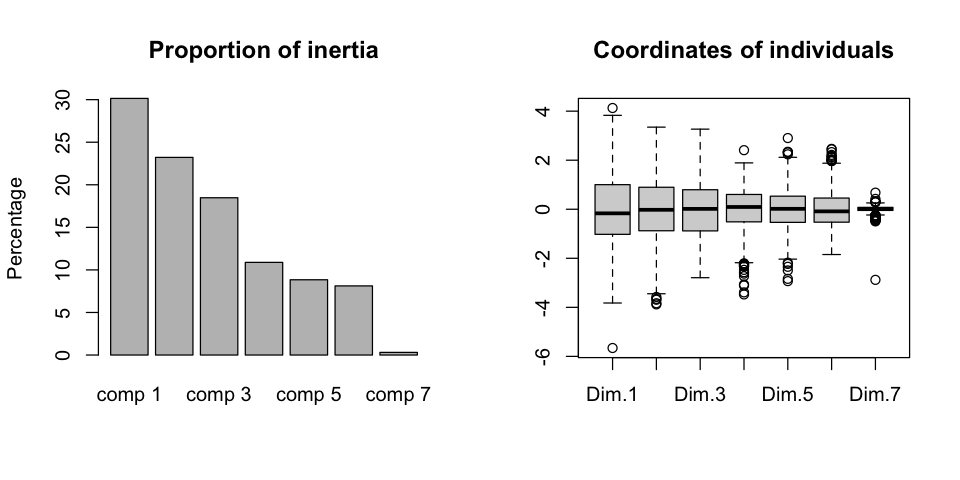

In [14]:
# ACP réduite
# Décroissance des valeurs propres
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
barplot(acp$eig[, 2], ylab = "Percentage", main = "Proportion of inertia")
boxplot(acp$ind$coord, main = "Coordinates of individuals")

In [15]:
help(PCA)

Warning message in seq_len(head.end.idx):
“seul le premier élément de l'argument 'length.out' est utilisé”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): l'argument doit être convertible automatiquement en un entier non négatif

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .

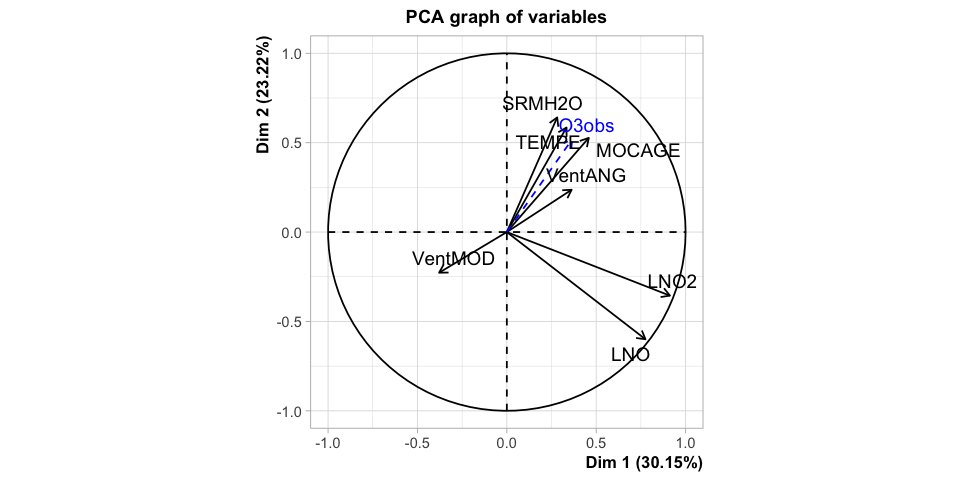

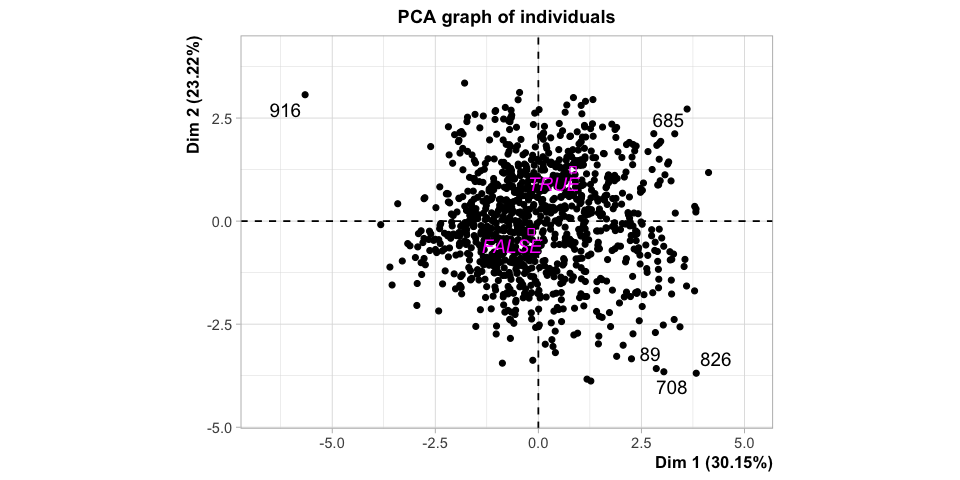

In [16]:
plot(acp, choix = "varcor")
plot(acp, choix = "ind", select = "contrib 5", unselect =0)

**Q** Que sont ces graphiques?

**R**: `Proportion of inertia` 
    
    Représente les variables obtenues grace au PCA par la combinaison des variables initiables afin de réduire le nombre de composants. Ici on remaque les quatres premières composante, nous permet de garder près de 80% de l'imformation de notre donnée. 
    
    `Coordinates of individuals` 
    Permet d'avoir les informations sur la moyenne, la médiane, le minimum, le maximum, le premier quantile, le troisieme quantile de chaque composants des variables de l'ACP obtenues.
    
    `PCA graph of variables` 
    Représente l'indice de corélation entre les variables. On peut remmarquer que les variables (LNO2, LNO) sont très proche sur le cercle, donc plus corelés.
    
    `PCA graph of inividuals`:
    Représente la projection des données en deux dimension en considérant les deux premières composants de l'ACP
    
    - Le graphe "PCA graph of individuals" montre les coordonnées de chaque échantillon dans les deux premières dimensions. On y trouve en rose les coordonnées de la variable qualitative supplémentaire (DepSeuil) pour ces deux dimensions. Les indexes des 5 élements les plus atypiques y sont représentés.
    
**Q** Que dire du choix de la dimension, des valeurs atypiques?

**R**: Le choix de deux dimensions ne représente qu'environ 53% de la variance. Il faudrait plutôt utiliser 3 dimensions afin d'avoir environ 71% de la variance. Les valeurs atypiques se retrouvent à l'exterieure du graphe et sont très facilement identifiables.

**Q** Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

Même graphe en coloriant les dépassement de seuil.

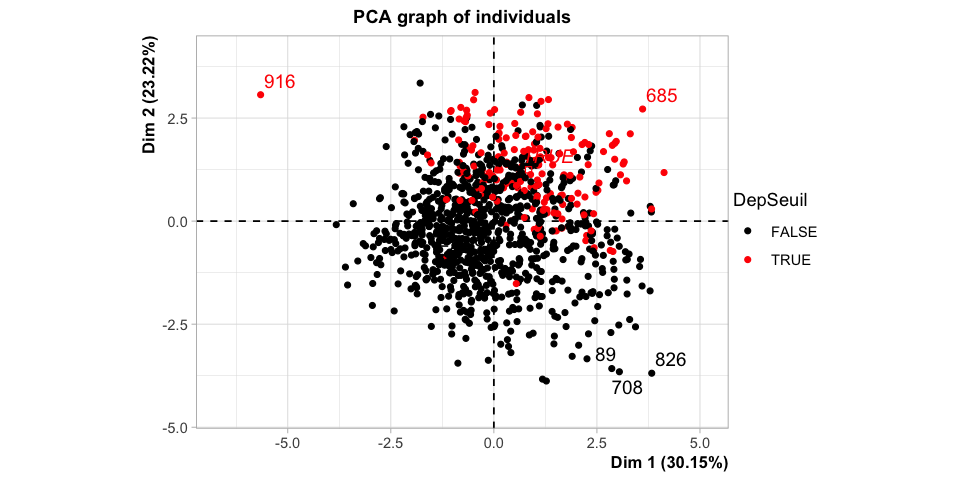

In [17]:
plot(acp, choix = "ind", habillage = 1,
     select = "contrib 5", unselect = 0)

L'objectif est donc de définir une surface séparant les deux classes. 

**Q** Une discrimination linéaire (hyperplan) semble-t-elle possible? 

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme k-means. Donne t-elle la même information ?

**R**: Une discrimination linéaire est n'est possible qu' à partir de 3 composante de l'ACP, ce qui nous donne une information à 71%.

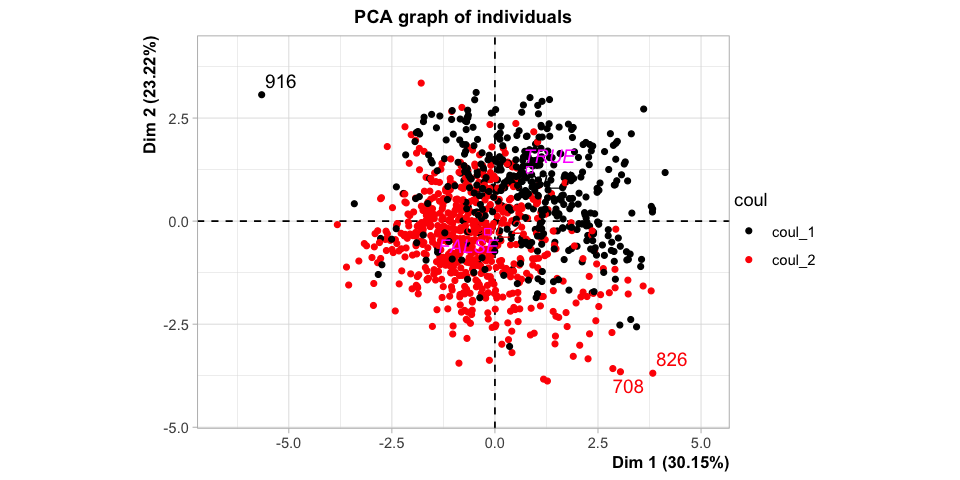

In [18]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(coul = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
plot(acp2, choix = "ind", habillage = "coul",
     select = "contrib 3", unselect = 0)

**R**: En analysant les résultats donnés par Kmeans, on remarque que Kmeans a su bien clusturiser les données comme le cas de discrimination linéaire.

## Protocole de comparaison

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Étape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

**Q** Comment appelle-t-on cette procédure spécifique de validation croisée?

* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

**R**: La méthode de validation croisée s'appelle le `k-fold cross validation` qui permet de construire k modeles ittérative dont chacun construit sur un echantillon de k-1(echantillon de la dataset) et le k ieme pour le test.

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test. 

Utiliser trois chiffres au hasard, et **remplacer** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats.

In [19]:
set.seed(123) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [20]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11] 
# construction de l'échantillon test
datestr <- ozone[testi, -11] 
# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ O3obs  : int  91 100 82 94 150 164 135 121 129 118 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 114.3 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 6.31 ...
 $ VentANG: num  -0.6435 -0.05 -0.1283 -0.3452 0.0634 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.1087 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 1.671 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 0.295 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 2 1 1 ...
 $ O3obs  : int  57 102 26 101 105 183 138 52 83 98 ...
 $ MOCAGE : num  105 114 187 112 148 ...
 $ TEMPE  : num  19.4 30.2 21.7 27.9 25.9 20.8 25 23.1 15.8 21.6 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 2 3 1 3 1 4 5 3 5 4 ...
 $ VentMOD: num  4.52 5.17 4

Construction des échantillons pour la discrimination: prévision de dépassement.

In [21]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2]
# construction de l'échantillon test 
datestq <- ozone[testi,-2] 

# vérification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 2 2 1 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 94.8 114.3 ...
 $ TEMPE   : num  21.5 20.2 17.4 18.8 23.6 26.6 23.5 23.3 23.7 22.2 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 9.46 6.31 ...
 $ VentANG : num  -0.6435 -0.05 -0.1283 -0.3452 0.0634 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0925 0.1087 ...
 $ LNO2    : num  0.471 0.752 0.505 0.854 1.671 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.355 0.295 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 2 1 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 1 1 2 1 1 2 1 2 1 1 ...
 $ MOCAGE  : num  105 114 187 112 148 ...
 $ TEMPE   : num  19.4 30.2 21.7 27.9 25.9 20.8 25 23.1 15.8 21.6 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 2 3 1 3 1 4 5 3 5 4 ...
 $ VentMOD : num  4.52 5.17 4.12 9.55 4 ...
 $ VentANG : 

Enfin, avant de passer aux différents algorithmes, définissons une fonction traçant le graphe des résidus avec des couleurs et des échelles fixes sur les axes. 

In [22]:
options(repr.plot.width = 8, repr.plot.height = 4)
# Définition d'une fonction pour un graphe coloré et des échelles fixes sur les
# axes
plot.res <- function(x, y, titre = "titre") {
    plot(x, y, col = "blue", xlim = c(0, 250), ylim = c(-100, 100), ylab = "Résidus", 
        xlab = "Valeurs prédites", main = titre, pch = 20)
    # points(x2, y, col='red')
    abline(h = 0, col = "green")
}

## [Prévision par modèle gaussien](http://wikistat.fr/pdf/st-m-app-select.pdf)

Le premier modèle à tester est un simple modèle de régression linéaire mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

### Modèle linéaire

#### Sans sélection de variables

Le modèle de régression linéaire simple intégre des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

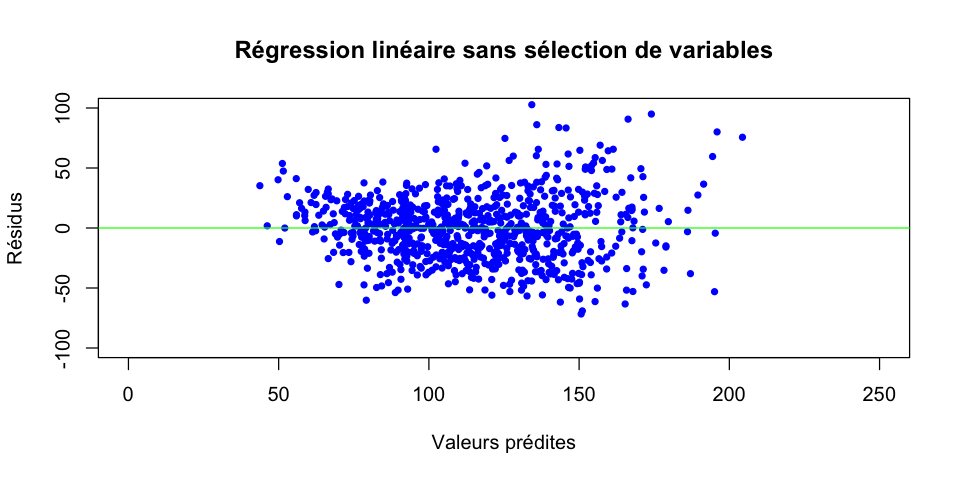

In [23]:
# estimation du modèle sans interaction
reg.lm <- aov(O3obs ~ . , data = datappr)

# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Graphe des résidus. 
plot.res(fit.lm,res.lm,"Régression linéaire sans sélection de variables")

**Q** Que dire de la distribution de ces résidus? 

**R**: On remarque que en fonction du nombre de données de prédiction, l'erreur qui est ici le résidu augumente.

**Q** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle?

**R**: Le modèle n'est pas linéaire car on a des donnée avec une grande erreur. Le modèle n'est donc pas adapté aux données.

Apprécier néanmoins sa significativité par la commande suivante.

In [24]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    964     964   1.243 0.265189    
MOCAGE        1 468441  468441 603.952  < 2e-16 ***
TEMPE         1 218521  218521 281.735  < 2e-16 ***
STATION       4   5100    1275   1.644 0.161242    
VentMOD       1  10574   10574  13.633 0.000237 ***
VentANG       1  12105   12105  15.607 8.47e-05 ***
SRMH2O        1   2815    2815   3.630 0.057114 .  
LNO2          1   1550    1550   1.999 0.157807    
LNO           1   9310    9310  12.003 0.000559 ***
Residuals   819 635238     776                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [25]:
coef(reg.lm)

(Intercept)       JOUR1      MOCAGE       TEMPE  STATIONAls  STATIONCad 
-15.1954608  -0.2322255   0.3978666   4.0207792  -0.1284525   9.3467447 
 STATIONPla  STATIONRam     VentMOD     VentANG      SRMH2O        LNO2 
 14.9083328   2.6748795  -1.1297309   4.9959620 117.2695826 -15.4707914 
        LNO 
 17.1237425

**Q** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

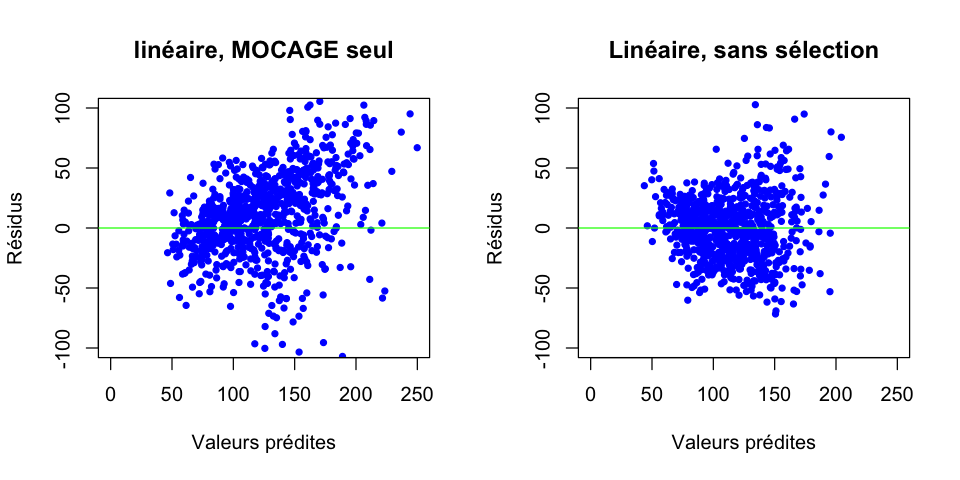

In [28]:
# Graphe des résidus du modèle déterministe MOCAGE
par(mfrow = c(1, 2))
plot.res(datappr[, "MOCAGE"],
         datappr[, "MOCAGE"] - datappr[, "O3obs"], "linéaire, MOCAGE seul")
plot.res(fit.lm, res.lm, "Linéaire, sans sélection")
par(mfrow = c(1, 1))

**R**: On peut donc conclure que l'utilsation du MOCAGE seul a plus d'erreur que l'utisation de plusieurs variable.

#### Sélection de variable par régularisation L1 (LASSO)

Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-3



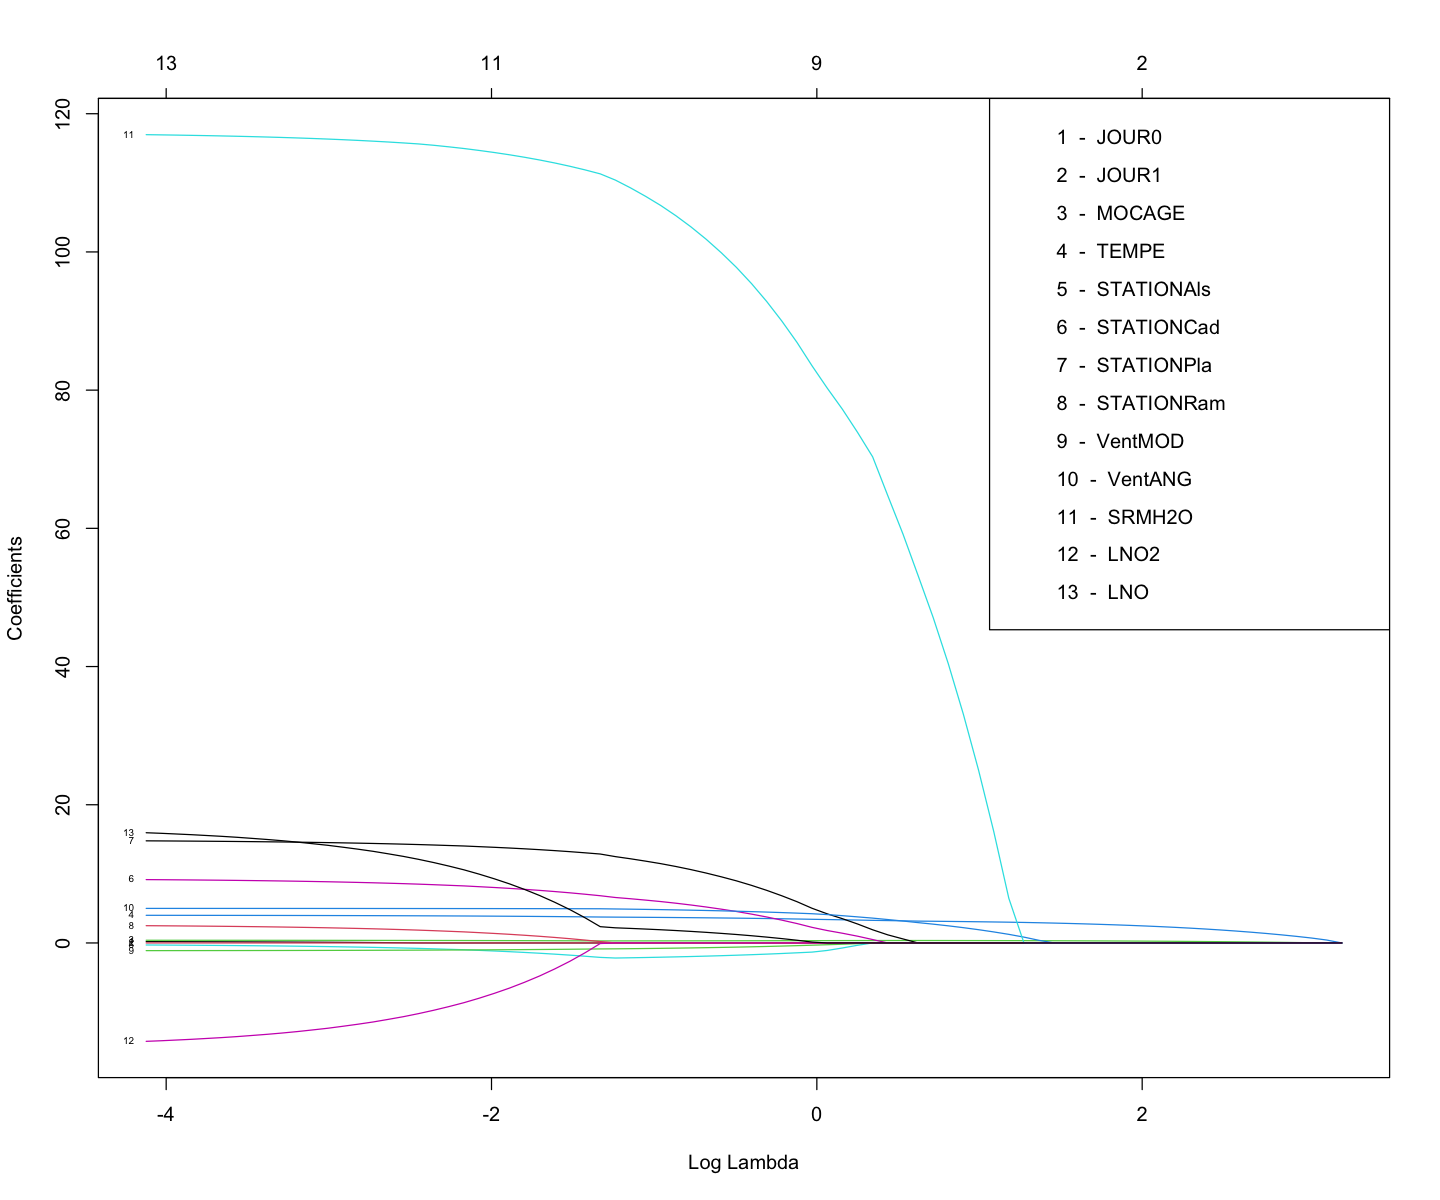

In [31]:
#install.packages("glmnet")
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . -1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

**Q** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

**R**: La commande model.matrix permet de transformer les variables catégorielles en binaire. Par exemple, Si un feature ne prend que 4 valeurs differentes, on va créer 4 nouveelles colonnes correspondante à chaque valeurs dont ses nouvelles valeurs seront binaire 0 ou 1.

**Q** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?

**R**: La courbe permet de selectionner les variables qui gardent plus d'information de la donnée en variant lambda. Plus lambda augumente, les coeficiants des variables diminuent vers 0.

In [32]:
#help(model.matrix)
head(x.mat)

JOUR0 JOUR1 MOCAGE TEMPE STATIONAls STATIONCad STATIONPla STATIONRam VentMOD
1 0     1      93.2  21.5  0          0          0          0          9.5000 
2 0     1     104.6  20.2  0          0          0          0          8.0100 
3 1     0     103.6  17.4  0          0          0          0          9.3771 
4 1     0      94.8  18.8  0          0          0          0          9.4578 
6 1     0     114.3  23.6  0          0          0          0          6.3127 
7 1     0     127.7  26.6  0          0          0          0          4.8042 
  VentANG  SRMH2O     LNO2      LNO       
1 -0.64350 0.09203260 0.4712528 -0.8580218
2 -0.04996 0.09386160 0.7518877 -0.6329933
3 -0.12832 0.09751923 0.5050087 -0.7614260
4 -0.34516 0.09246621 0.8544153 -0.3552474
6  0.06341 0.10871982 1.6707211  0.2949059
7  0.04164 0.09679876 1.0441561 -0.5978370

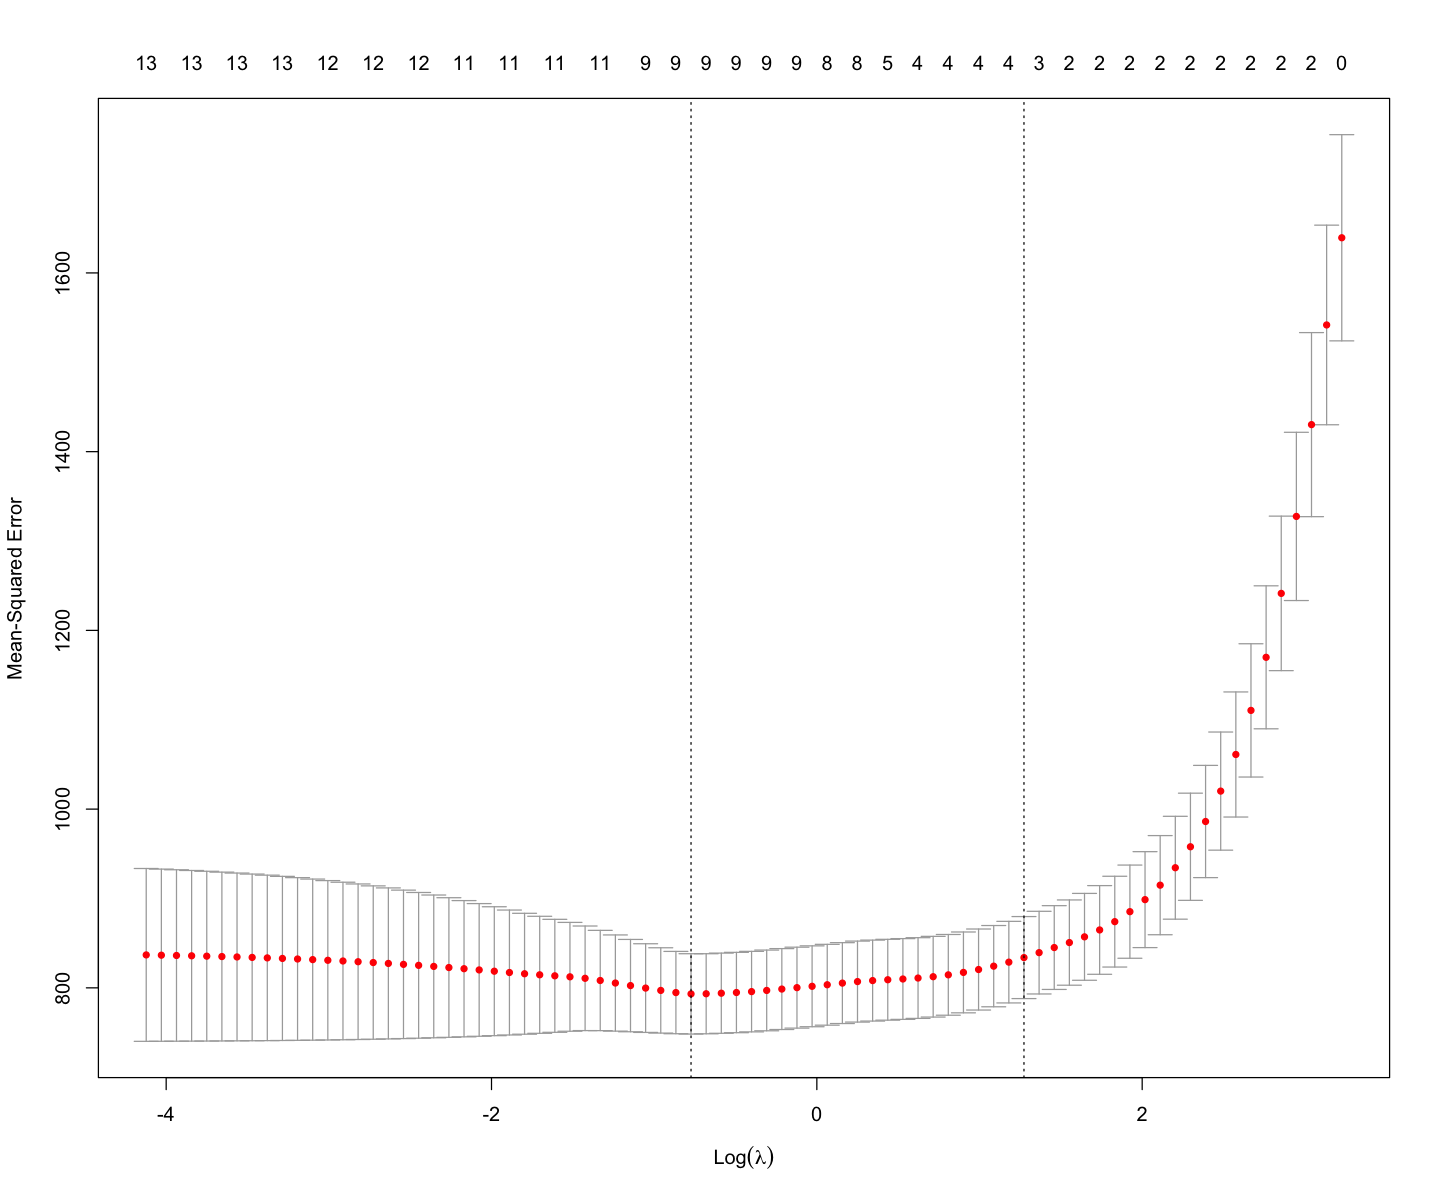

In [33]:
# choix du paramètre de régularisation par validation croisée
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
plot(reg.lasso.cv)

In [24]:
library(glmnet)
help(cv.glmnet)

**Q** Que représente la courbe rouge ? Et la bande qui est autour ? 

**R**: La courbe rouge représente l'erreur quadratique moyenne en fonction du lambda. La bande autour est l'écart type de l'erreur quadratique moyenne en fonction du lambda. 

**Q** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?


In [35]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

[1] "CV estimate of lambda : 0.461"

14 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -19.6479845
JOUR0         .        
JOUR1         .        
MOCAGE        0.3072467
TEMPE         3.6587258
STATIONAls   -1.9623652
STATIONCad    5.4905714
STATIONPla   10.6115081
STATIONRam    .        
VentMOD      -0.7172606
VentANG       4.7444935
SRMH2O      103.6163971
LNO2          .        
LNO           1.6725730

**Q** Combien restent-ils de coefficients non nuls. Vérifier sur les chemins de régularisation.

**R**: Il reste 3 coeffcients non nuls sur le schema de régulation. 

**Q** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. "reg.lasso.cv$lambda.min"

**R**: En calculant coef(reg.lasso,s=0.461) on déduit qu'il reste 9 coefficients non nuls ce que confirme le schema.

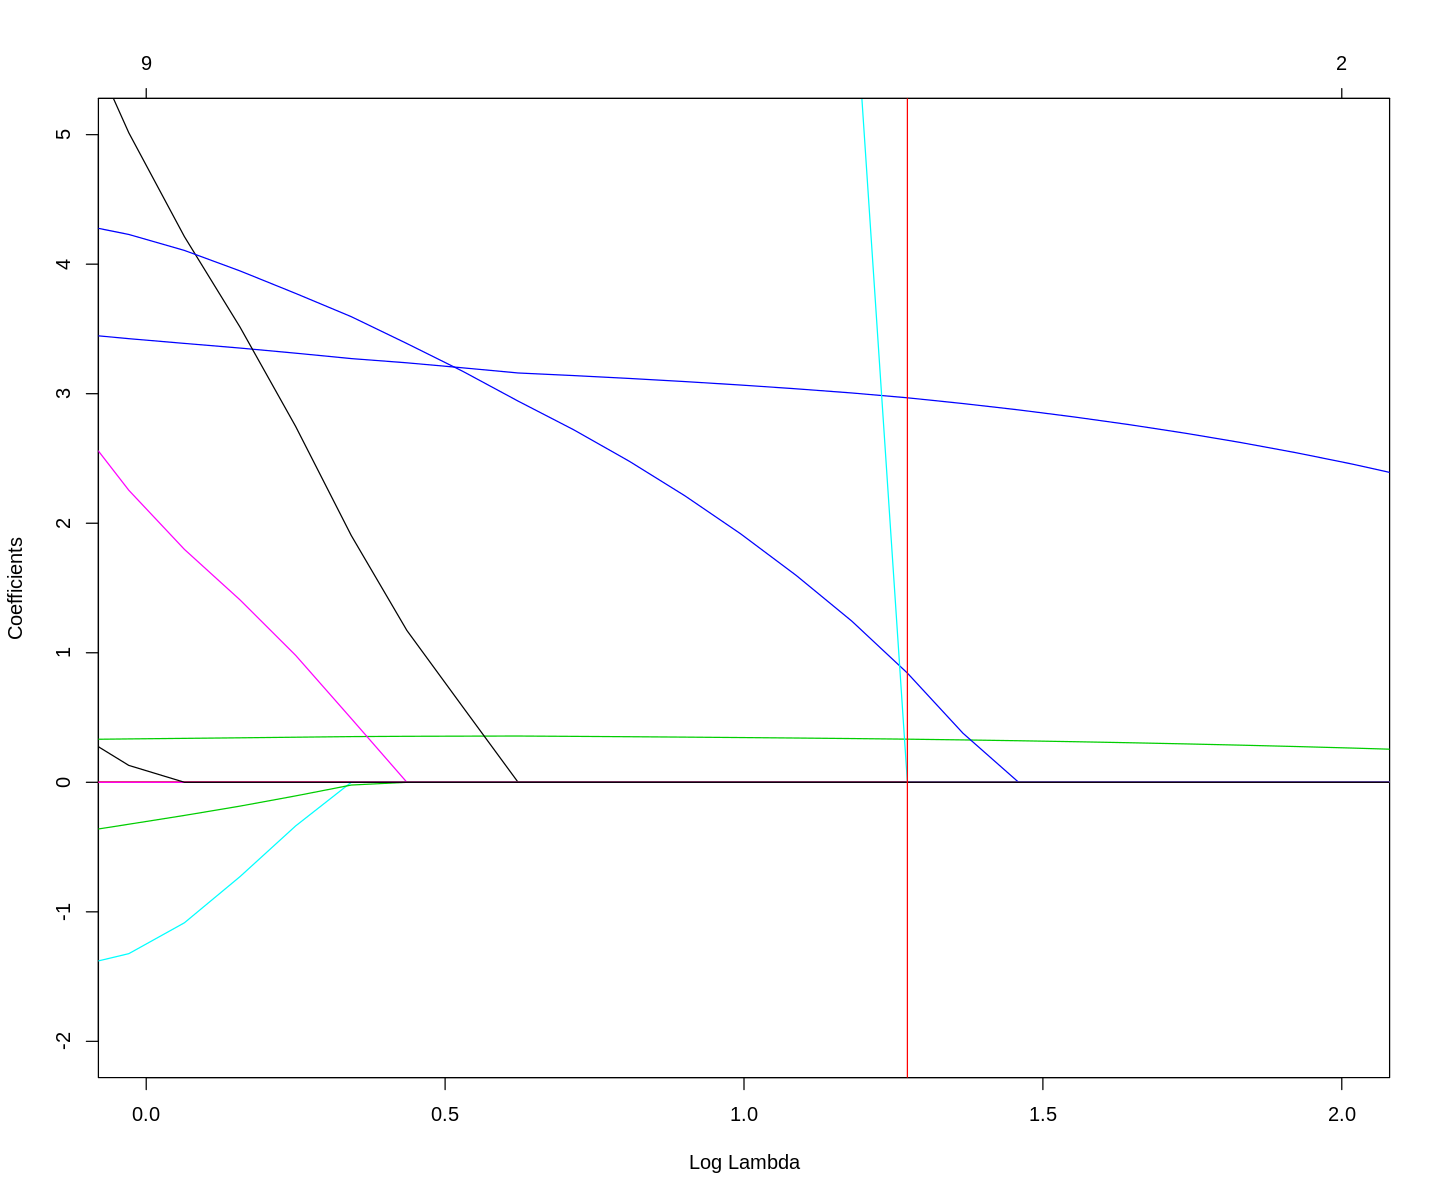

In [26]:
# NEW : 
plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(0,2),ylim=c(-2,5))
abline(v=log(reg.lasso.cv$lambda.1se),col="red")

[1] "CV estimate of lambda : 0.461"

14 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -19.6479845
JOUR0         .        
JOUR1         .        
MOCAGE        0.3072467
TEMPE         3.6587258
STATIONAls   -1.9623652
STATIONCad    5.4905714
STATIONPla   10.6115081
STATIONRam    .        
VentMOD      -0.7172606
VentANG       4.7444935
SRMH2O      103.6163971
LNO2          .        
LNO           1.6725730

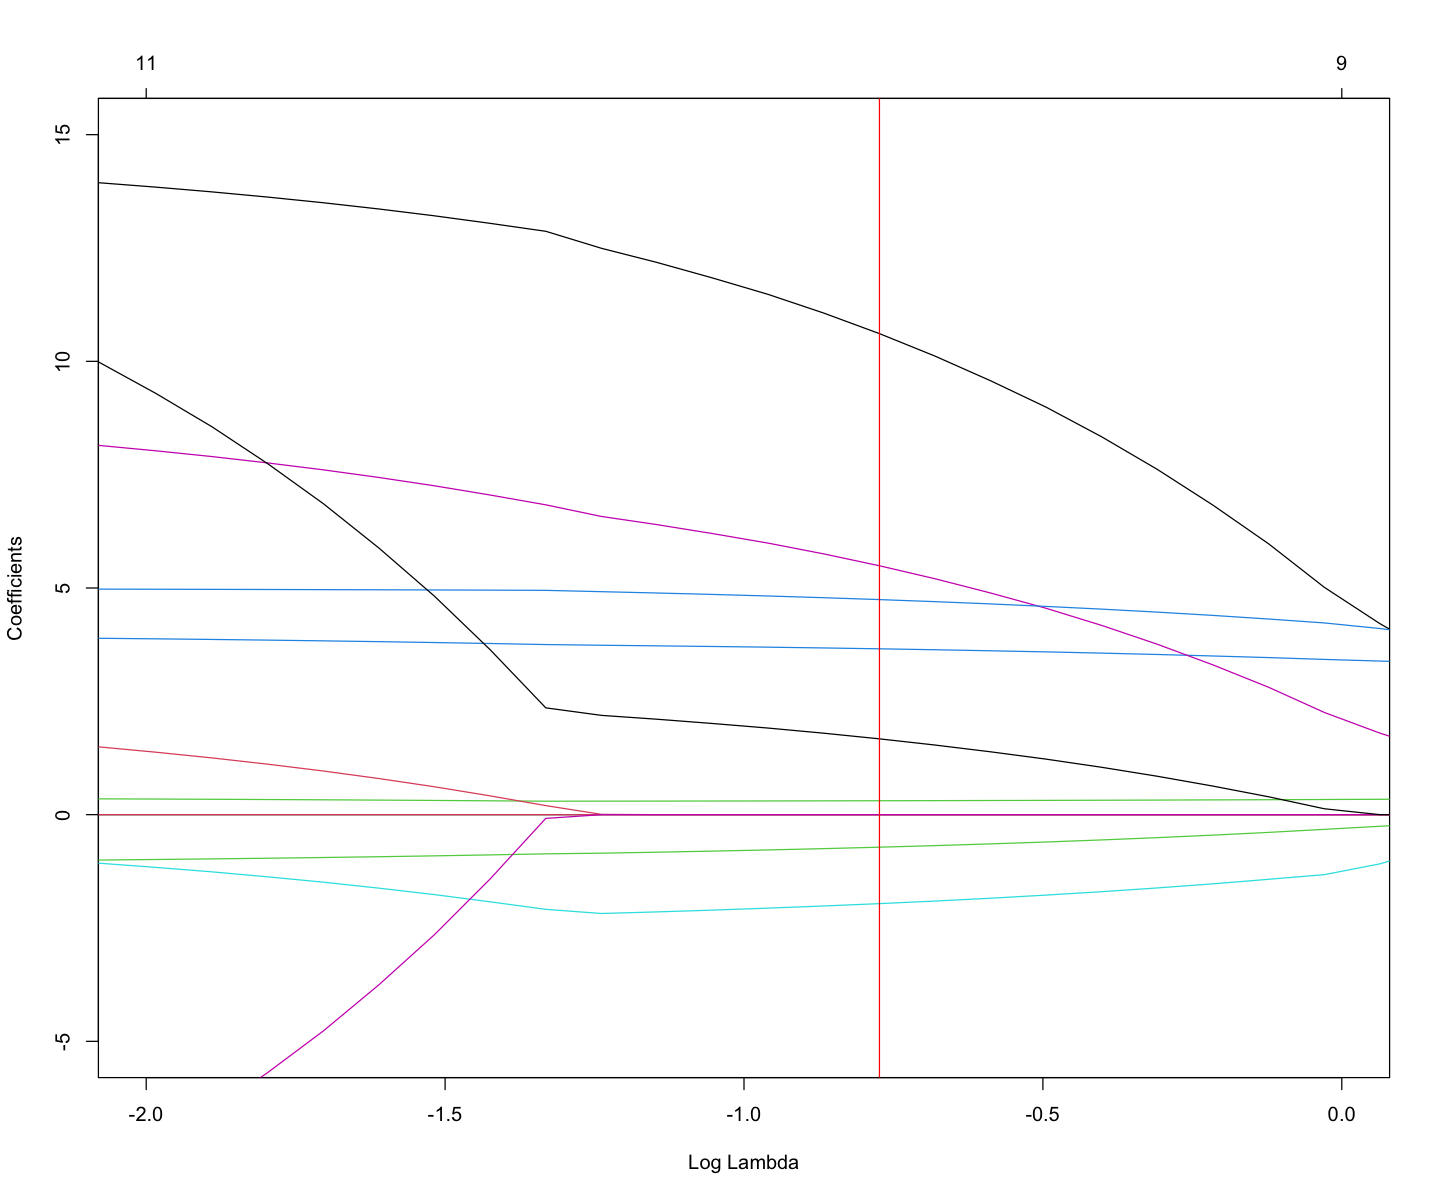

In [36]:

# NEW : 
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

plot(reg.lasso, xvar = "lambda", label = TRUE,xlim=c(-2,0),ylim=c(-5,15))
abline(v=log(reg.lasso.cv$lambda.min),col="red")

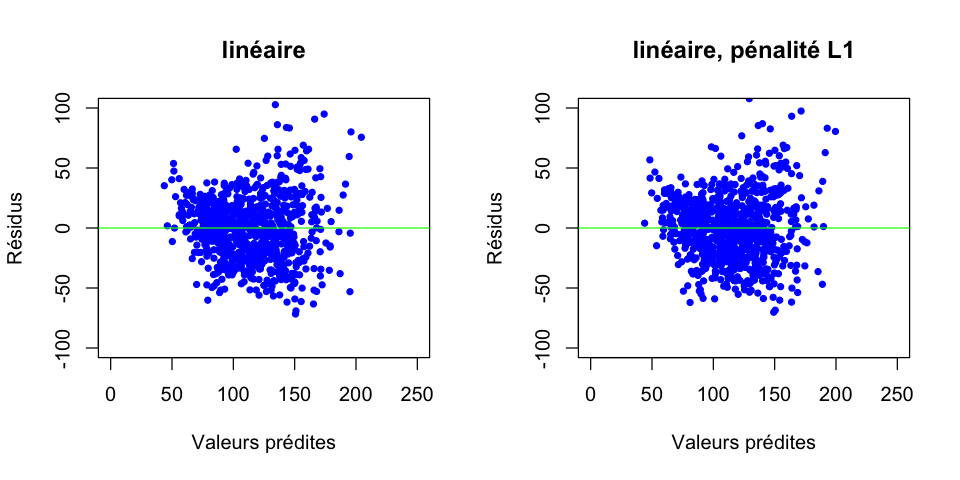

In [42]:
# Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso
# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

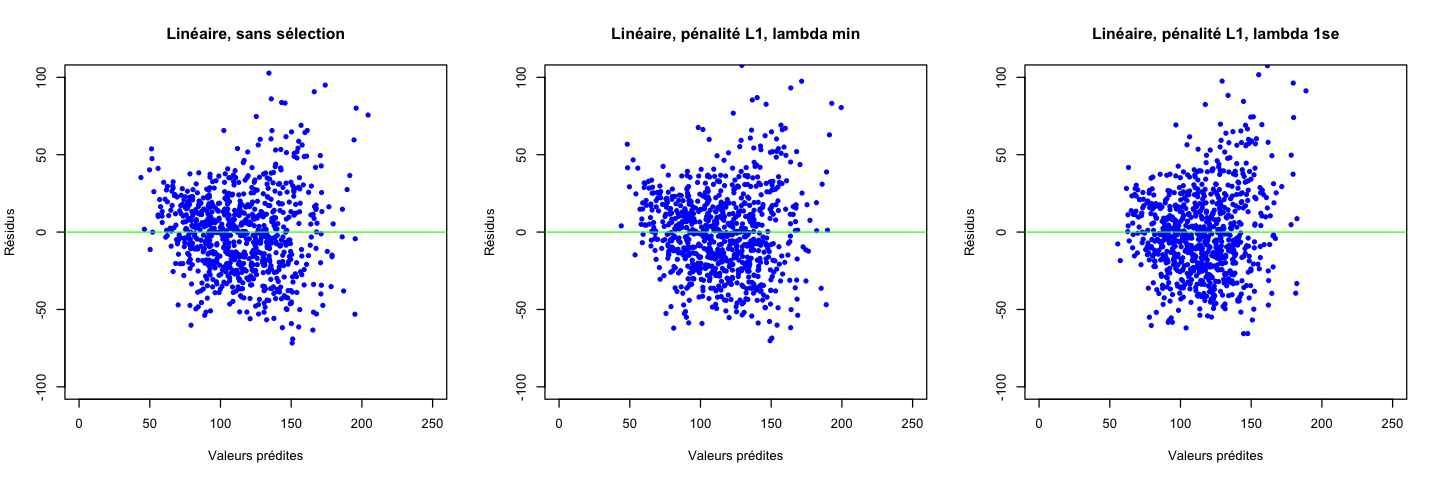

In [43]:
# Extraction des valeurs ajustées et des résidus

fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat) # NEW
res.lasso.1se <- datappr$O3obs - fit.lasso.1se # NEW

# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 4)
par(mfrow = c(1, 3))
plot.res(fit.lm, res.lm, "Linéaire, sans sélection")
plot.res(fit.lasso, res.lasso, "Linéaire, pénalité L1, lambda min")
plot.res(fit.lasso.1se, res.lasso.1se, "Linéaire, pénalité L1, lambda 1se") # NEW

**Q1** Commenter. 

**R1**: La regression de Lasso avec le lambda min est la meme que la regression linéaire (schema 1 et 2). Pour lambda 1st on constate sur le schema 3 une variance assez homogene.

**Q2** Calculer le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

**Q3** Estimer l'erreur de généralisation du modèle de régression linéaire simple sans sélection de variables par validation croisée. Comparer avec celle du LASSO. Qu'observez-vous?

In [30]:
# NEW : 
paste("Modèle linéaire sans séletion:",mean(res.lm^2))
paste("LASSO avec lambda.min:",mean(res.lasso^2))
paste("LASSO avec lambda.1se:",mean(res.lasso.1se^2))

[1] "Modèle linéaire sans séletion: 763.507246231797"

[1] "LASSO avec lambda.min: 774.89614845961"

[1] "LASSO avec lambda.1se: 826.516162786774"

**R2**: 
    LASSO minimise le nombre de coefficients utilisés dans la fonction de regression linéaire et selectionne les variables qui gardent le maximum d'information.

In [31]:
# NEW
V=10 ; nV=floor(nrow(datappr)/V)
S=sample(1:nrow(datappr),replace=FALSE)
error.CV = c()
for(v in 1:V)
{ # Rq : les deux dernières obs sont tjs dans l'échantillon d'apprentissage...
    datappr.learn=datappr[-c(S[(nV*(v-1)):(nV*v)]),] 
    datappr.valid=datappr[c(S[(nV*(v-1)):(nV*v)]),]
    error.CV=c(error.CV,mean((datappr.valid$O3obs-predict(aov(O3obs ~ ., data=datappr.learn),newdata=datappr.valid))^2))
}
mean(error.CV)

print(reg.lasso.cv)

[1] 844.5252


Call:  cv.glmnet(x = x.mat, y = datappr[, 2]) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.461    44   793.2 44.95       9
1se  3.573    22   833.9 45.89       3


**R3**: Le Mean-Square Error de la regression simple est supérieur à ceux de LASSO (lambda.min et lambda.1se)
     La régression de LASSO donne une meilleur généralisation que la régression simple sans sélection

### Modèle quadratique

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction glm qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC ou *Akaïke Information Criterion*. 

**Q** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisée en régression linéaire? 


**R**: Le critère d'information baysien (BIC)

In [44]:
# Estimation du modèle de toute interaction d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7775.04
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- STATION:VentANG  4   466934 7767.8
- JOUR:STATION     4   467365 7768.5
- STATION:LNO      4   468272 7770.1
- STATION:LNO2     4   468532 7770.6
- JOUR:LNO         1   466536 7773.1
- VentMOD:VentANG  1   466536 7773.1
- LNO2:LNO         1   466564 7773.1
- JOUR:MOCAGE      1   466567 7773.1
- MOCAGE:LNO2      1   466592 7773.2
- MOCAGE:LNO       1   466608 7773.2
- JOUR:LNO2        1   466614 7773.2
- VentMOD:LNO2     1   466647 7773.3
- TEMPE:VentANG    1   466810 7773.5
- TEMPE:VentMOD    1   466816 7773.6
- VentANG:SRMH2O   1   466890 7773.7
- JOUR:TEMPE       1   466924 7773.7
- VentMOD:LNO      1   466977 7773.8
- JOUR:SRMH2O      1   467300 7774.4
- JOUR:VentANG     1   467615 7775.0
<none>                 466530 7775.0
- VentANG:LNO2     1   467806 7775.3
- VentMOD:SRMH2O   1   467808 7775.3
- MOCAGE:VentANG   1   467855 7775.4


In [45]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

Df Deviance     Resid. Df Resid. Dev F            Pr(>F)       
NULL            NA           NA 831       1364618.9            NA            NA
JOUR             1 9.642305e+02 830       1363654.7  1.595718e+00  2.068876e-01
MOCAGE           1 4.684412e+05 829        895213.5  7.752295e+02 4.365858e-119
TEMPE            1 2.185214e+05 828        676692.1  3.616340e+02  1.437557e-66
STATION          4 5.099857e+03 824        671592.2  2.109955e+00  7.780965e-02
VentMOD          1 1.057406e+04 823        661018.2  1.749916e+01  3.199949e-05
VentANG          1 1.210514e+04 822        648913.0  2.003296e+01  8.743243e-06
SRMH2O           1 2.815143e+03 821        646097.9  4.658817e+00  3.119815e-02
LNO2             1 1.550295e+03 820        644547.6  2.565603e+00  1.096148e-01
LNO              1 9.309566e+03 819        635238.0  1.540652e+01  9.432718e-05
JOUR:VentMOD     1 1.103409e+03 818        634134.6  1.826046e+00  1.769861e-01
JOUR:SRMH2O      1 2.974118e+00 817        634131.6  4.921906e-03  9.440872e-01
JOUR:LNO2        1 1.717527e+03 816        632414.1  2.842357e+00  9.220833e-02
MOCAGE:TEMPE     1 2.375982e+04 815        608654.3  3.932043e+01  5.945033e-10
MOCAGE:STATION   4 1.181568e+04 811        596838.6  4.888482e+00  6.743940e-04
MOCAGE:VentMOD   1 1.031712e+04 810        586521.5  1.707394e+01  3.983065e-05
MOCAGE:VentANG   1 4.461983e+01 809        586476.9  7.384195e-02  7.858946e-01
MOCAGE:SRMH2O    1 5.528819e+03 808        580948.1  9.149715e+00  2.568995e-03
TEMPE:STATION    4 1.915165e+04 804        561796.4  7.923578e+00  2.909346e-06
TEMPE:SRMH2O     1 2.320473e+04 803        538591.7  3.840182e+01  9.307658e-10
TEMPE:LNO2       1 6.427885e+03 802        532163.8  1.063759e+01  1.156148e-03
TEMPE:LNO        1 9.258699e+02 801        531237.9  1.532234e+00  2.161489e-01
STATION:VentMOD  4 8.027961e+03 797        523210.0  3.321395e+00  1.038019e-02
STATION:SRMH2O   4 1.333297e+04 793        509877.0  5.516227e+00  2.209552e-04
STATION:LNO2     4 7.346383e+03 789        502530.6  3.039406e+00  1.676988e-02
VentMOD:SRMH2O   1 8.459170e+02 788        501684.7  1.399919e+00  2.370967e-01
VentMOD:LNO      1 1.600019e+03 787        500084.7  2.647892e+00  1.040901e-01
VentANG:SRMH2O   1 9.152064e+02 786        499169.5  1.514587e+00  2.188105e-01
VentANG:LNO2     1 2.162477e+03 785        497007.0  3.578712e+00  5.889374e-02
VentANG:LNO      1 1.650870e+04 784        480498.3  2.732047e+01  2.213652e-07
SRMH2O:LNO2      1 2.729312e+01 783        480471.0  4.516774e-02  8.317513e-01
SRMH2O:LNO       1 7.938645e+03 782        472532.4  1.313777e+01  3.081301e-04

#### Sélection de variable par régularisation L1 (LASSO)

In [46]:
# Comparer avec un modèle quadratique avec pénalité L1
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)         6.125297e+01
JOUR0               .           
JOUR1               .           
MOCAGE              .           
TEMPE               .           
STATIONAls          .           
STATIONCad          .           
STATIONPla          .           
STATIONRam          .           
VentMOD             .           
VentANG             .           
SRMH2O             -3.240123e+02
LNO2                .           
LNO                 .           
JOUR1:MOCAGE        .           
JOUR1:TEMPE         .           
JOUR1:STATIONAls    .           
JOUR1:STATIONCad    .           
JOUR1:STATIONPla    .           
JOUR1:STATIONRam    .           
JOUR1:VentMOD       .           
JOUR1:VentANG       .           
JOUR1:SRMH2O        .           
JOUR1:LNO2          8.633905e-03
JOUR1:LNO           7.383135e-01
MOCAGE:TEMPE        1.176907e-02
MOCAGE:STATIONAls   .           
MOCAGE:STATIONCad   .           
M

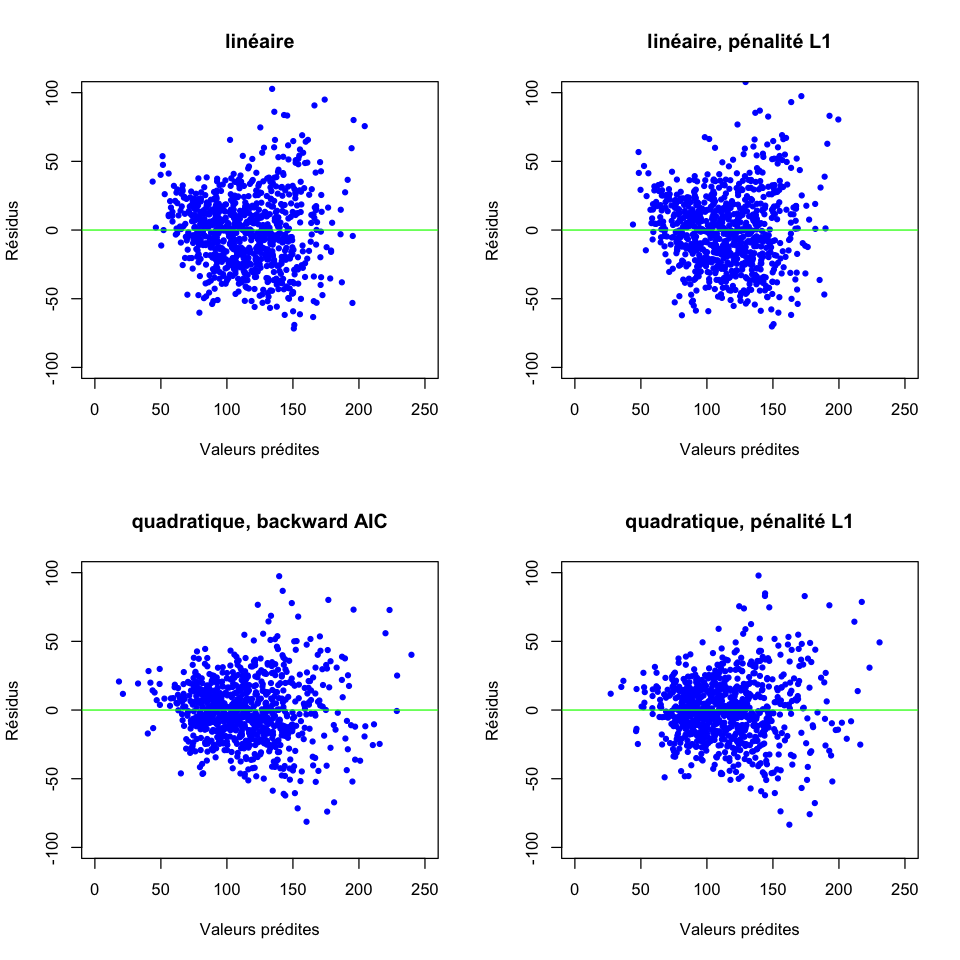

In [47]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(2, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
plot.res(fit.glm, res.glm, "quadratique, backward AIC")
plot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")

 On remarque que la présence de certains interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.
 
Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.

### Prévision de l'échantillon test

Le modèle "optimal" obtenu par la méthode stepwise est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées ; la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés. 

#### Erreur de régression

In [48]:
# Calcul des prévisions pour le nomdèle quadratique backward AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 632.1576

In [49]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1577.113

#### Erreur de classification (matrice de confusion)

In [50]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   157   18
  TRUE      8   26

In [51]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   131   14
  TRUE     34   30

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

## [Prévision par modèle binomial](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.

### Régression logistique sans interaction

In [52]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significativité des paramètres
anova(log.lm, test = "Chisq")

Df Deviance    Resid. Df Resid. Dev Pr(>Chi)    
NULL    NA          NA 831       734.5222             NA
JOUR     1   0.1647852 830       734.3575   6.847886e-01
MOCAGE   1 117.5971083 829       616.7604   2.124401e-27
TEMPE    1 149.8623985 828       466.8980   1.857959e-34
STATION  4  14.1091275 824       452.7888   6.954788e-03
VentMOD  1  11.1636715 823       441.6252   8.341468e-04
VentANG  1   1.6809416 822       439.9442   1.947994e-01
SRMH2O   1  16.3403451 821       423.6039   5.292510e-05
LNO2     1   0.2082303 820       423.3956   6.481580e-01
LNO      1   6.3539128 819       417.0417   1.171227e-02

In [53]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=443.04
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   417.04 441.04
- JOUR     1   417.07 441.07
<none>         417.04 443.04
- VentANG  1   419.16 443.16
- VentMOD  1   420.89 444.89
- LNO2     1   422.16 446.16
- LNO      1   423.40 447.40
- STATION  4   436.03 454.03
- SRMH2O   1   434.14 458.14
- TEMPE    1   531.55 555.55

Step:  AIC=441.04
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   417.07 439.07
<none>         417.04 441.04
- VentANG  1   419.18 441.18
- VentMOD  1   421.11 443.11
- LNO2     1   427.72 449.72
- LNO      1   427.88 449.88
- SRMH2O   1   434.40 456.40
- STATION  4   443.26 459.26
- TEMPE    1   536.28 558.28

Step:  AIC=439.07
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
<none>         417.07 439.07
- VentANG  1   419.18 439.18

In [54]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq")

Df Deviance    Resid. Df Resid. Dev Pr(>Chi)    
NULL    NA          NA 831       734.5222             NA
TEMPE    1 235.1882740 830       499.3340   4.404738e-53
STATION  4  24.9944161 826       474.3396   5.044004e-05
VentMOD  1  24.8315098 825       449.5080   6.256632e-07
VentANG  1   2.6215573 824       446.8865   1.054209e-01
SRMH2O   1  18.5675412 823       428.3189   1.639892e-05
LNO2     1   0.4134857 822       427.9055   5.202056e-01
LNO      1  10.8350627 821       417.0704   9.959595e-04

In [55]:
# matrice de confusion de l'échantillon d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   678   65
  TRUE     20   69

In [56]:
table(predict(log.lm.step, newdata = datestq, type="response")>0.5,datestq[,"DepSeuil"])

       
        FALSE TRUE
  FALSE   159   25
  TRUE      6   19

### Régression logistique avec interactions

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique  rencontre des soucis et affiche des *warnings* car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure *forward* ou  mieux *stepwise* de sélection des variables et interactions  conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [57]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

Start:  AIC=736.52
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   499.33 503.33
+ MOCAGE   1   616.81 620.81
+ SRMH2O   1   665.18 669.18
+ STATION  4   713.89 723.89
+ VentANG  1   723.09 727.09
+ LNO2     1   727.96 731.96
+ LNO      1   730.71 734.71
+ VentMOD  1   732.07 736.07
<none>         734.52 736.52
+ JOUR     1   734.36 738.36

Step:  AIC=503.33
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   466.91 472.91
+ SRMH2O   1   468.52 474.52
+ STATION  4   474.34 486.34
+ VentANG  1   489.75 495.75
+ VentMOD  1   491.61 497.61
+ LNO      1   495.73 501.73
<none>         499.33 503.33
+ JOUR     1   499.32 505.32
+ LNO2     1   499.33 505.33
- TEMPE    1   734.52 736.52

Step:  AIC=472.91
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   446.96 454.96
+ STATION       4   452.83 466.83
+ LNO           1   460.34 468.34
+ VentANG       1   461.91 469.91
+ LNO2          1   462.00 470.00
+ VentMOD       1   463.96 471.96
<none>  

In [58]:
anova(log.qm.step1, test = "Chisq")

Df Deviance   Resid. Df Resid. Dev Pr(>Chi)    
NULL           NA         NA 831       734.5222             NA
TEMPE           1 235.188274 830       499.3340   4.404738e-53
MOCAGE          1  32.423381 829       466.9106   1.239857e-08
SRMH2O          1  19.948650 828       446.9619   7.955010e-06
STATION         4  16.500681 824       430.4613   2.415908e-03
VentMOD         1   5.396408 823       425.0649   2.017824e-02
LNO             1   1.118036 822       423.9468   2.903418e-01
SRMH2O:STATION  4  12.400521 818       411.5463   1.460862e-02
TEMPE:SRMH2O    1   5.378442 817       406.1679   2.038708e-02
MOCAGE:VentMOD  1   7.111395 816       399.0565   7.659548e-03
MOCAGE:STATION  4  12.921689 812       386.1348   1.166484e-02
STATION:LNO     4  15.765331 808       370.3694   3.350775e-03
TEMPE:MOCAGE    1   8.418402 807       361.9510   3.714421e-03

### Prévision de l'échantillon test

#### Matrice de confusion

In [61]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   162   24
  TRUE      3   20

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

#### [Courbe ROC](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)

Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

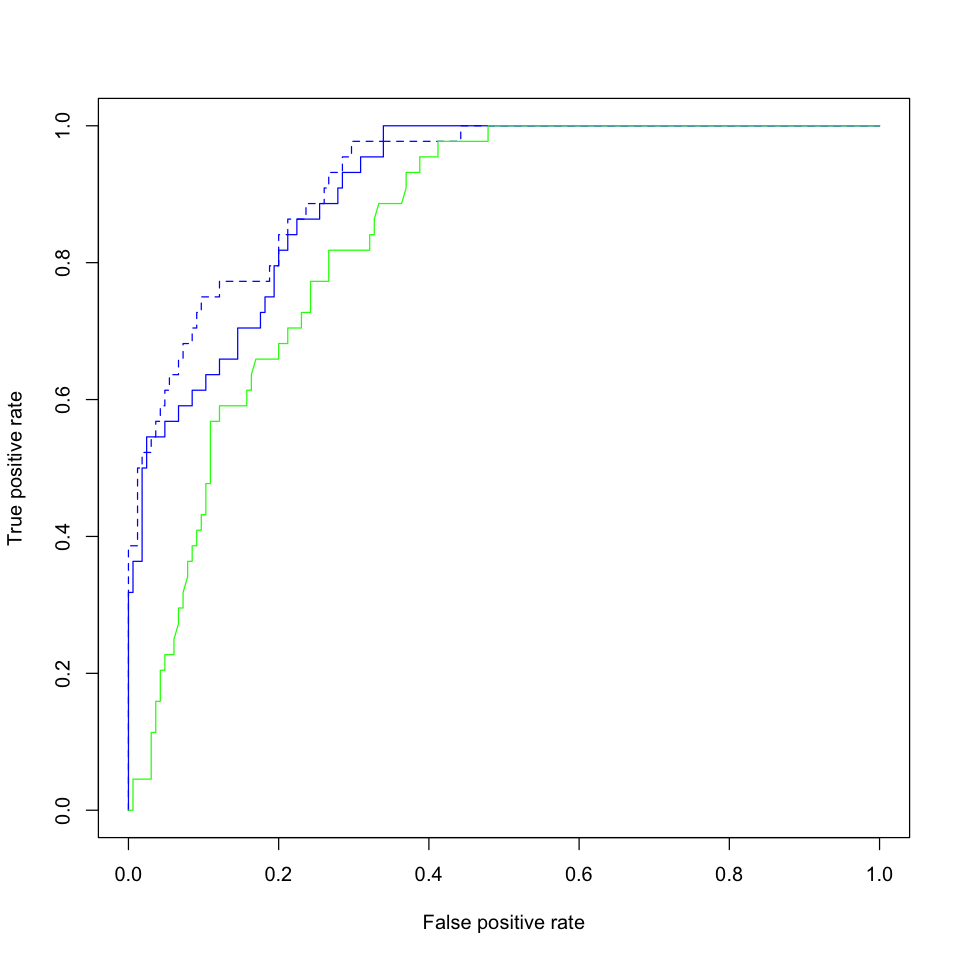

In [64]:
#install.packages("ROCR") 
library(ROCR)   # Librairie à charger
roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")
# Tracé de la courbe
plot(perflogit, col = "blue")

# Calculs pour la régression
rocglm <- pred.glm / 300
predglm <- prediction(rocglm, datestq[, "DepSeuil"])
perfglm <- performance(predglm, "tpr", "fpr")
# tracé de la courbe et ajout au graphe précédent.
plot(perfglm, col = "blue",lty=2, add = TRUE)

# Calculs pour mocage
rocmcg <- datestq[,"MOCAGE"]/300
predmcg <- prediction(rocmcg, datestq[,"DepSeuil"])
perfmcg <- performance(predmcg, "tpr", "fpr")

plot(perfmcg, col="green", add = TRUE)

**Q** Que sont sensibilité et spécificité d'une courbe ROC?

**R**: La sensibilité est le taux d'une courbe ROC est le True Positif et la spécificité c'est la prédiction corect des négatifs. En absice la spécificité et en ordonné la sensibilité.

Les résultats obtenus dépendent évidemment en plus de l'échantillonnage initial entre apprentissage et test. Dans le cas où les courbes se croisent, cela signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle. Ceci souligne l'importance de la bonne définition du critère à utiliser pour le choix d'une "meilleure" méthode. Ce choix dépend directement de celui , "politique" ou "économique" de sensibilité et / ou spécificité du modèle retenu. En d'autres termes, quel taux de fausse alerte, avec des imputations économiques évidentes, est supportable au regard des dépassements non détectés et donc de la dégradation sanitaire de la population à risque ?
 
C'est une fois ce choix arrêté que le statisticien peut opérer une comparaison des méthodes en présence.

**Q** Les performances des deux approches gaussiennes et binomiales sont-elles très différentes?

**R**: Les deux approches sont similaires avec une légere efficacité du modèle de l'approche binomiale

**Q** Sur le graphe ci-dessus, ajouter la courbe ROC pour le modèle déterministe MOCAGE. Qu'observez-vous?

**R**: Le modele MOCAGE est moins performant par rapport au modele binomial.

# <FONT COLOR="Red">Épisode 2</font>

## [Arbre de décision binaire](http://wikistat.fr/pdf/st-m-app-cart.pdf)

La librairie  `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbre peuvent être estimer selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres  contrôlent l'exécution de l'algorithme: la pénalisation  minimale (`cp`) pour la construction de l'arbre maximal, le nombre minimal d'observation par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (?rpart.control) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres, c'est le travers des logiciels "libres".

**NB.** Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.


### Estimation et élagage de l'arbre de régression
**Q** Quel critère est optimisé lors de la création d'un noeud? de l'arbre?

**R:** Lors de la création du noeud on minimise l'entropie.
Dans la création de l'arbre on cherche à minimiser le nombre de noeuds.

In [65]:
library(rpart) # chargement de la librairie
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu
# summary(tree.reg)  
# mais un graphe est  préférable

In [66]:
library(rpart)
help(rpart)


Warning message in seq_len(head.end.idx):
“seul le premier élément de l'argument 'length.out' est utilisé”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): l'argument doit être convertible automatiquement en un entier non négatif

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .

In [67]:
help(rpart.control)

Warning message in seq_len(head.end.idx):
“seul le premier élément de l'argument 'length.out' est utilisé”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): l'argument doit être convertible automatiquement en un entier non négatif

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .

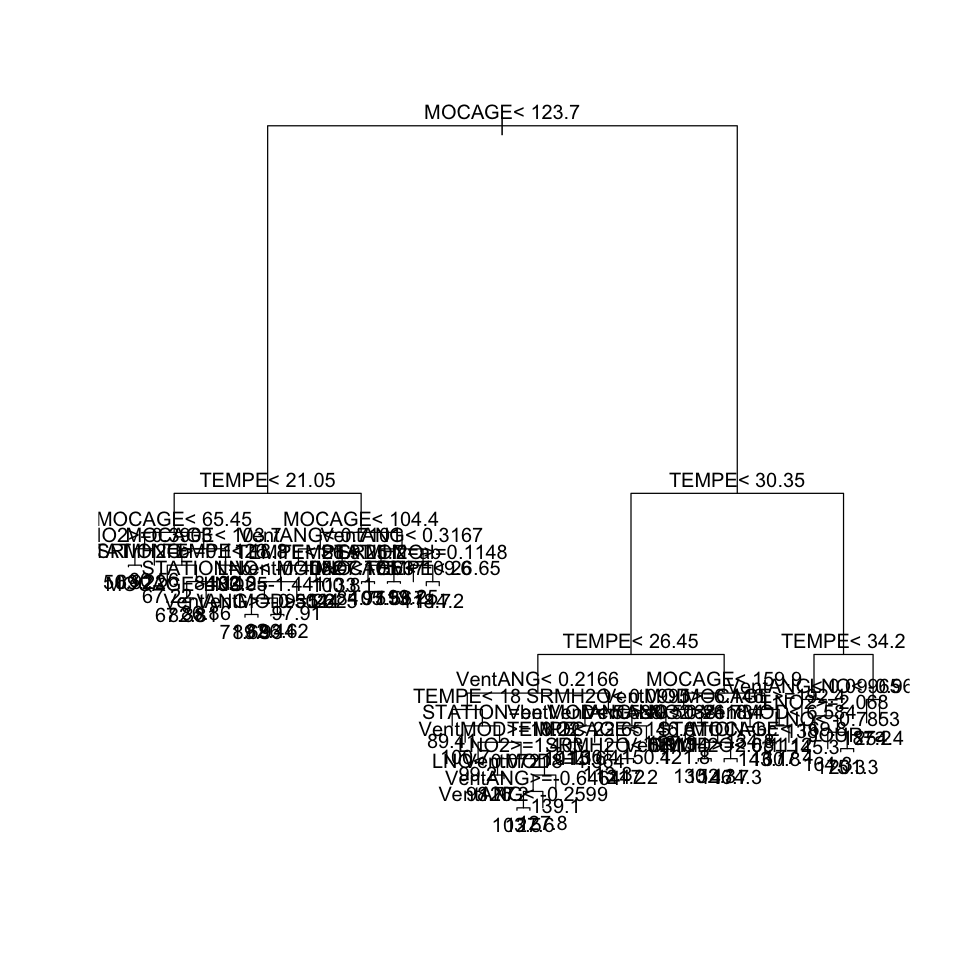

In [68]:
plot(tree.reg)
text(tree.reg)

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par  validation croisée *10-fold* pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`. 

In [69]:
xmat=xpred.rpart(tree.reg)
xerr=(xmat-datappr[,"O3obs"])^2
CVerr=apply(xerr,2,sum)
CVerr  #    CP           erreur

0.647780753 0.195699336 0.068471265 0.033705827 0.031226107 0.024089524 
  1366127.6    979920.2    843009.5    813489.6    774586.1    735908.0 
0.015760172 0.012039757 0.010292658 0.009359961 0.008045403 0.007153927 
   719252.7    725797.1    721684.5    724288.2    724934.9    712491.5 
0.007011381 0.006419232 0.005501988 0.004689540 0.004257638 0.004163285 
   709953.1    708942.9    701117.5    713817.5    714227.5    713681.2 
0.004069034 0.003932711 0.003819614 0.003728972 0.003618204 0.003377124 
   715342.3    716503.3    716765.1    715815.6    711776.0    716970.4 
0.003211632 0.003147809 0.002976777 0.002847325 0.002745533 0.002645498 
   721016.6    727163.8    734632.6    737691.8    737066.8    737308.6 
0.002552392 0.002477944 0.002449890 0.002358546 0.002249134 0.002093837 
   738264.4    736617.9    736148.6    731748.5    728980.2    728977.9 
0.001945615 0.001838697 0.001680111 0.001577115 0.001517606 0.001435031 
   727883.7    727701.2    733700.3    738787.8    737061.2    736498.9 
0.001351654 0.001293376 0.001253506 0.001138011 0.001042467 0.001014201 
   736984.8    738121.5    740405.7    741506.1    739638.5    740770.4

In [70]:
help(xpred.rpart)

Warning message in seq_len(head.end.idx):
“seul le premier élément de l'argument 'length.out' est utilisé”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): l'argument doit être convertible automatiquement en un entier non négatif

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .

Chercher la valeur de `cp` correspondant à la plus petite erreur puis l'utiliser la construction del'arbre.

In [71]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.005501988

In [72]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

La librairie `partykit` propose une construction graphique de l'arbre:

Le chargement a nécessité le package : grid

Le chargement a nécessité le package : libcoin

Le chargement a nécessité le package : mvtnorm



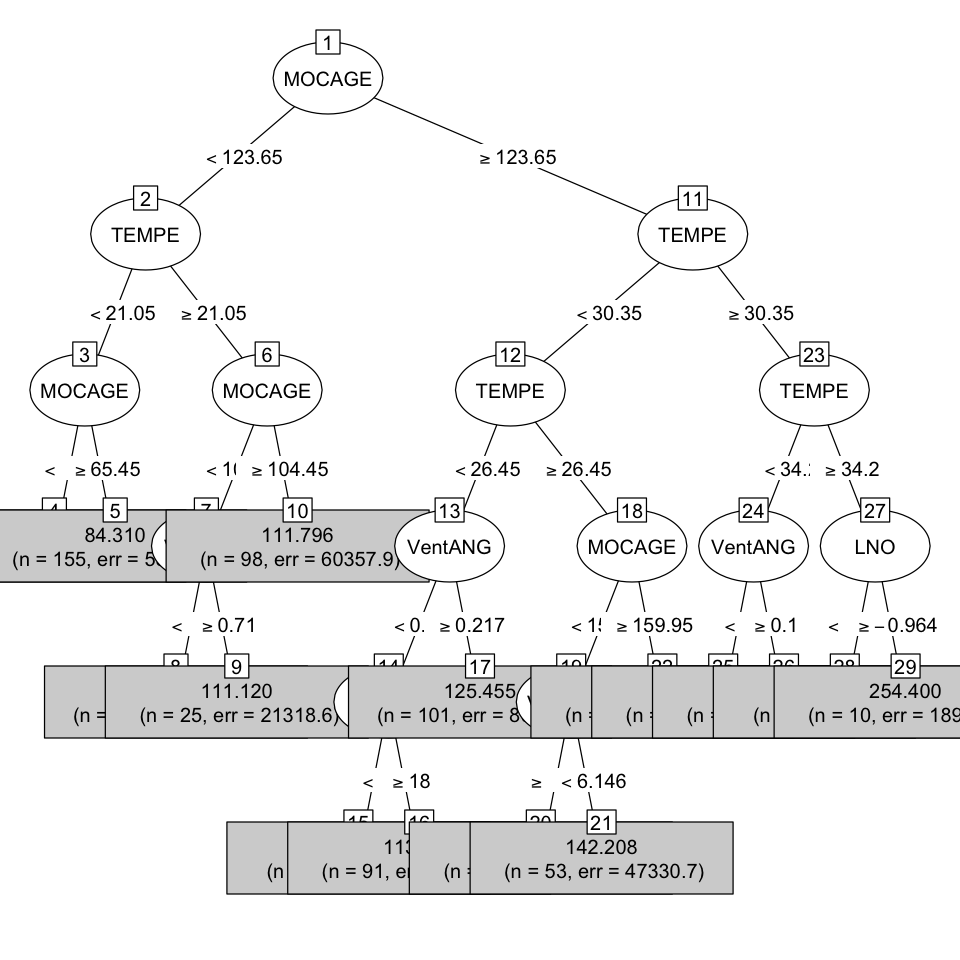

In [77]:
#install.packages("partykit") 
library(partykit)
plot(as.party(tree.reg), type="simple")

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille. 

**Q** Quelle est la variable qui contribue le plus à l'interprétation?

Graphe des résidus

**R:** MOCAGE etant à la racine de l'arbre, elle a été choisie apres calcule de l'entropie comme le meilleur en gain d'informaton

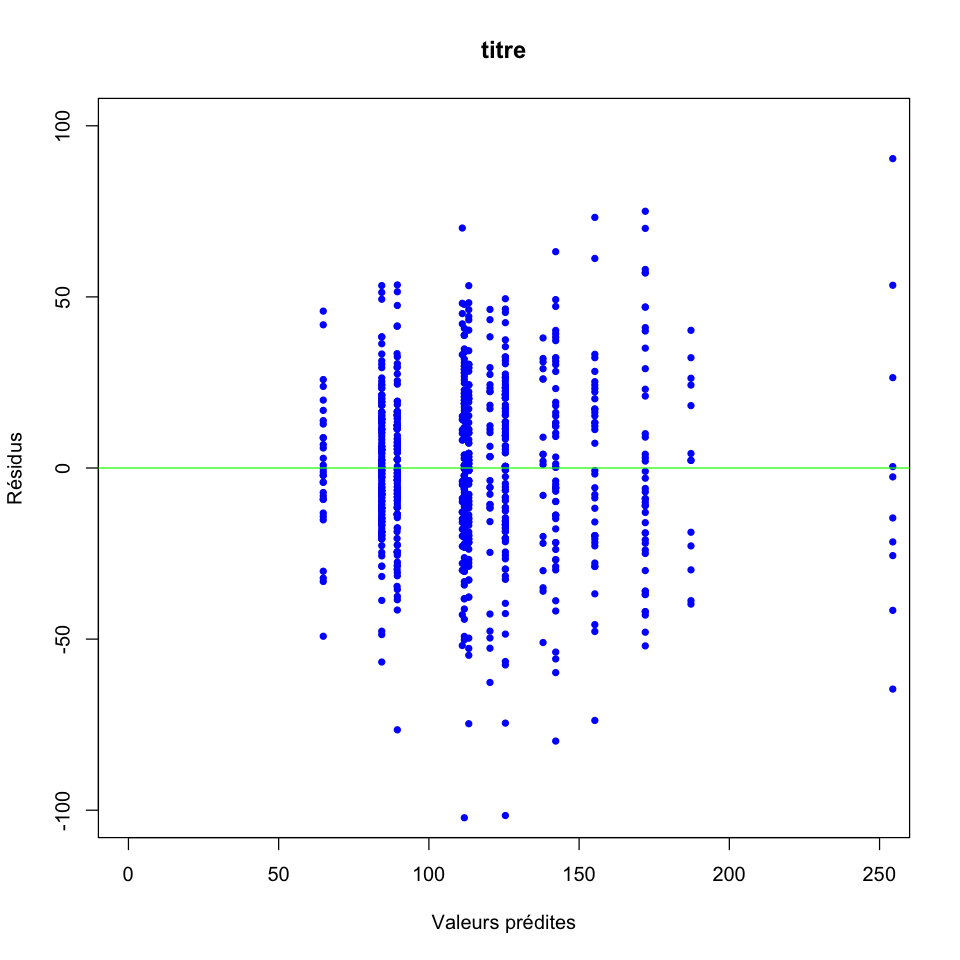

In [78]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
plot.res(fit.tree,res.tree)

**Q** A quoi est due la structure particulière de ce graphe?

### Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités *a priori* (?rpart pour plus de détails).

**Q** Quel autre critère d'hétérogénéité est utilisé?

**R:** le critère d'entropie.

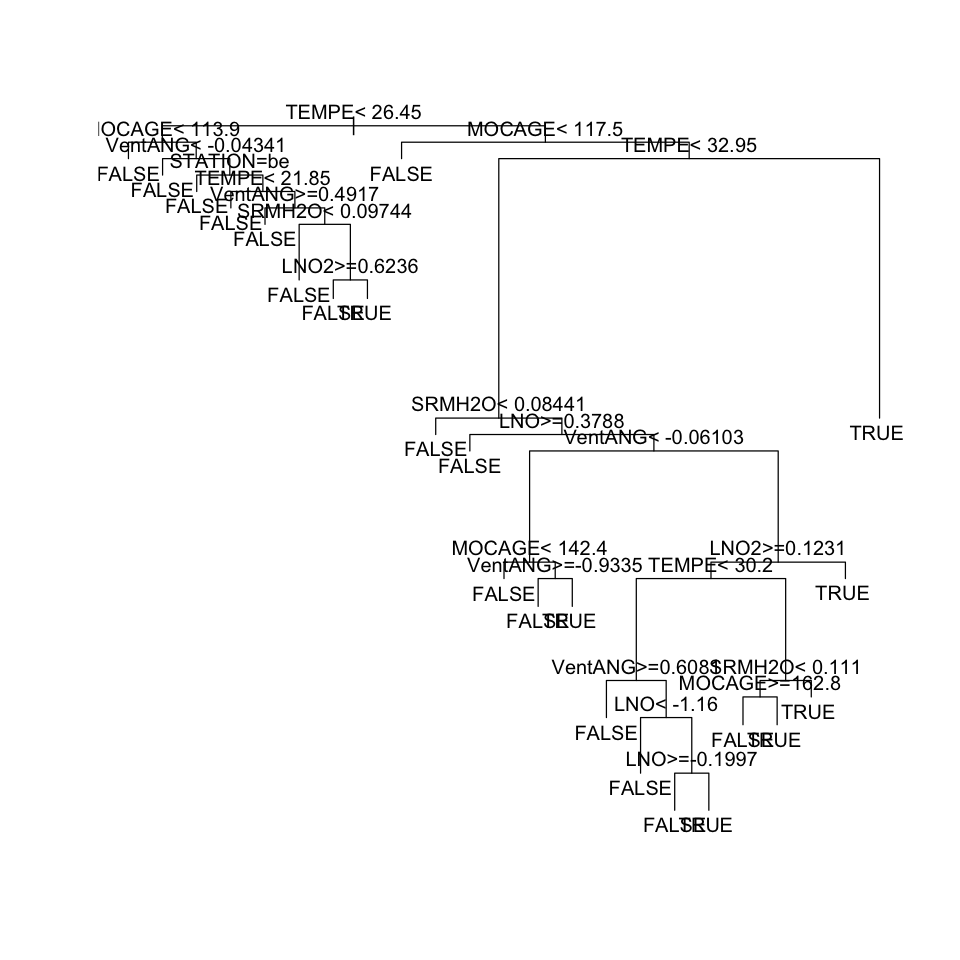

In [80]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
plot(tree.dis) 
text(tree.dis)  

La même procédure d'élagage par validation croisée est mise en place mais avec un expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [81]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

0.534825871 0.045597768 0.018279774 0.009139887 0.002731792 
  0.1610577   0.1478365   0.1514423   0.1550481   0.1586538

In [82]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.04559777

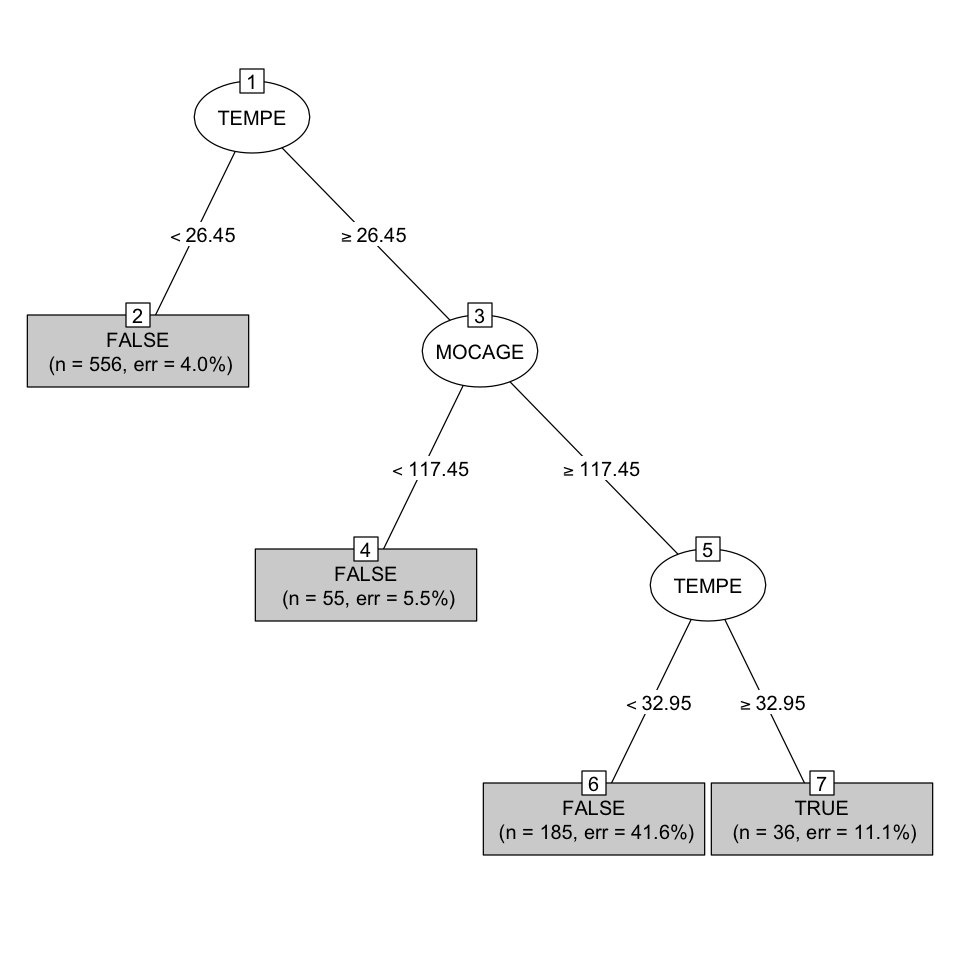

In [83]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),
               cp=as.numeric(attributes(which.min(CVerr))$names))
plot(as.party(tree.dis), type="simple")

### Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 

#### Erreur de régression

In [84]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr)
pred.treeq=predict(tree.dis,newdata=datestq,type="class") 
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 889.8637

#### Erreur de classification (matrice de confusion)

In [85]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.treer>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   155   22
  TRUE     10   22

In [80]:
# Même chose pour l'arbre de discrimination
table(pred.treeq,datestq[,"DepSeuil"])

          
pred.treeq FALSE TRUE
     FALSE   165   37
     TRUE      0    7

**Q** Quelle stratégie semble meilleure à ce niveau?

**R:** La stratégie de régression semble meilleur car leur faux négatifs et True Positifs sont plus conséquents

#### Courbes ROC

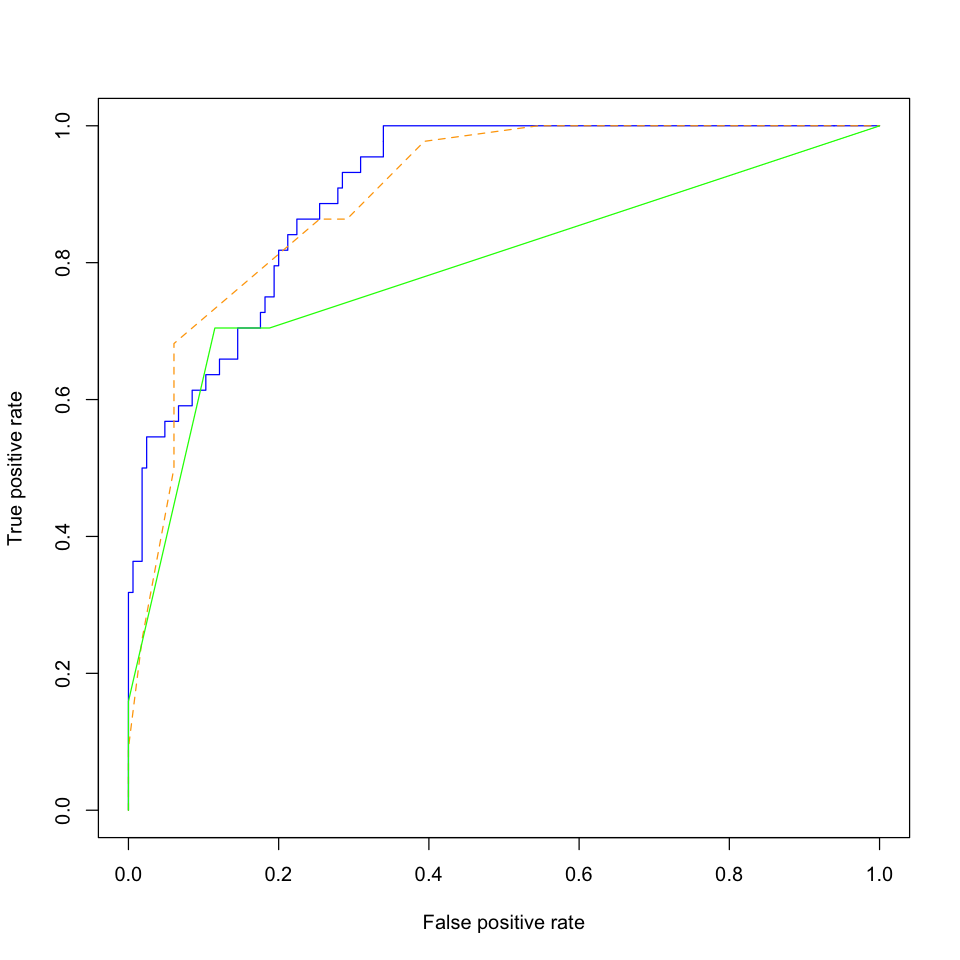

In [87]:
ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col="blue")
plot(perfregtree,col="orange",lty=2,add=TRUE) 
plot(perfdistree,col="green",add=TRUE)  

Comparer les qualités  de prévision.

**Q** Une meilleure méthode se dégage-t-elle?

**R:** Oui la meilleure méthode est bien évidenment la regression logistique

# <FONT COLOR="Red">Épisode 3</font>

## [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

### Introduction

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence. 

**Q** Quelle fonction de transfert pour le dernier neurone en régression ?

**R:** La fonction identité.

**Q** Quelle focntion de transfert pour le dernier neuronne en discrimination binaire?

**R:** La fonction sigmoïde.

**Q** Quid de la discrimination avec plusieurs classes?

**R:** La fonction `softmax`.

**Q** Quel est le choix par défaut pour les neurones de la couche cachée?

**R:** La fonction sigmoïde.

Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première conciste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée. 

**Q** Quel est le paramètre `decay` de la fonction `nnet`?

**R:** Le decay est le parametre de régulation la valeur des poids pour éviter qu'il prennent des valeurs abérantes.

**Q** Indiquer une autre façon déviter le sur-apprentissage.

**R:** La diminution du nombre de neuronne dans la couche cachée.

### Cas de la régression

In [88]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  71
initial  value 12120405.429390 
iter  10 value 1818839.286341
iter  20 value 1262835.277659
iter  30 value 1250334.884802
iter  40 value 1094920.863355
iter  50 value 774316.259082
iter  60 value 750340.589951
iter  70 value 673612.744292
iter  80 value 617950.102944
iter  90 value 601308.536613
iter 100 value 595857.913901
iter 110 value 572440.622294
iter 120 value 552498.739292
iter 130 value 545294.663283
iter 140 value 534903.893984
iter 150 value 531838.390700
iter 160 value 524611.995343
iter 170 value 512521.548430
iter 180 value 499939.023960
iter 190 value 498293.326489
iter 200 value 496940.800382
iter 210 value 491154.663983
iter 220 value 484404.943164
iter 230 value 483313.256637
iter 240 value 483204.633977
iter 250 value 483187.723251
iter 260 value 483186.731631
final  value 483186.721713 
converged


a 12-5-1 network with 71 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   1.31    0.00   -0.69    7.03    0.01    0.10    1.20    0.00    4.07    2.65 
i10->h1 i11->h1 i12->h1 
   0.07    0.14    2.42 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.83   -0.51    0.08    0.16    1.15   -0.27    0.12    0.93   -0.23    0.85 
i10->h2 i11->h2 i12->h2 
 -14.05   -6.53    6.19 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -5.01   27.36   -0.06    1.50   -4.13   14.98   31.46   11.51   -2.37   -3.59 
i10->h3 i11->h3 i12->h3 
  -5.47   -6.96    3.09 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
 -23.48    0.03   -0.01    0.49    2.07    0.34    2.71   -1.15    0.10    0.40 
i10->h4 i11->h4 i12->h4 
  31.22    2.73   -2.35 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constituent pas des résultats très explicites ! Contrôler le nombre de poids estimés.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

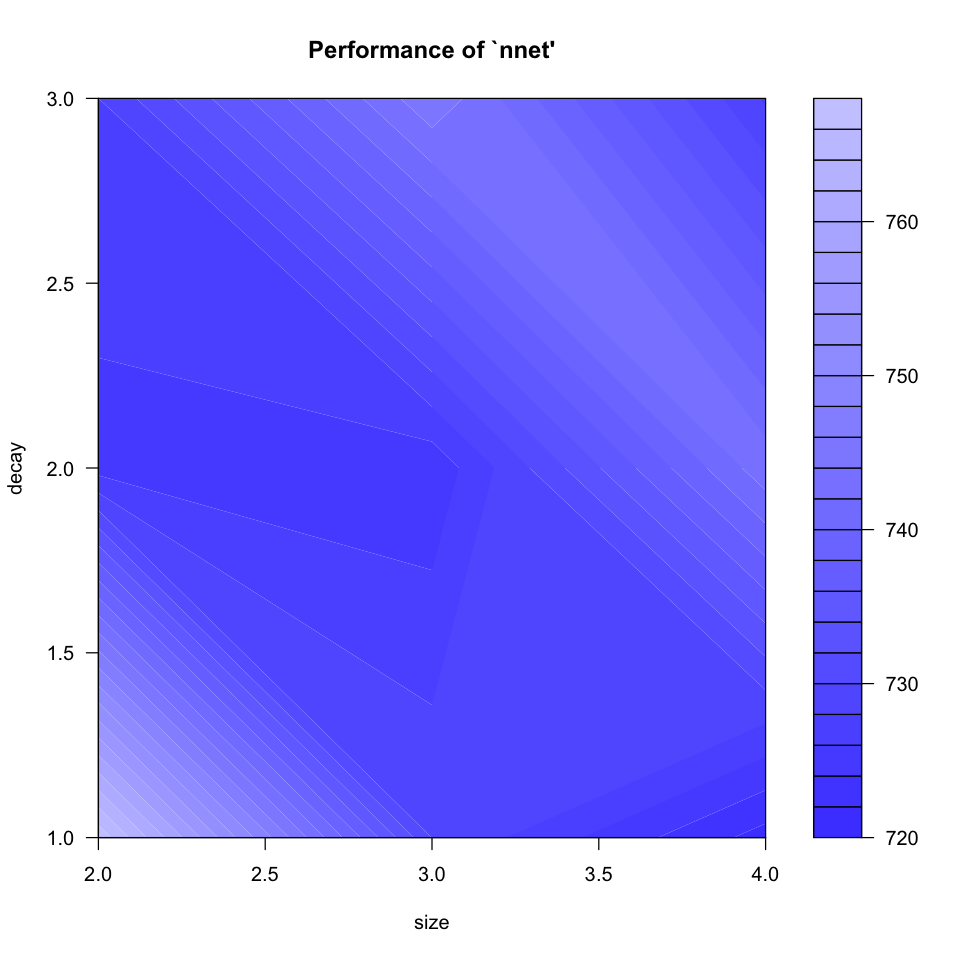

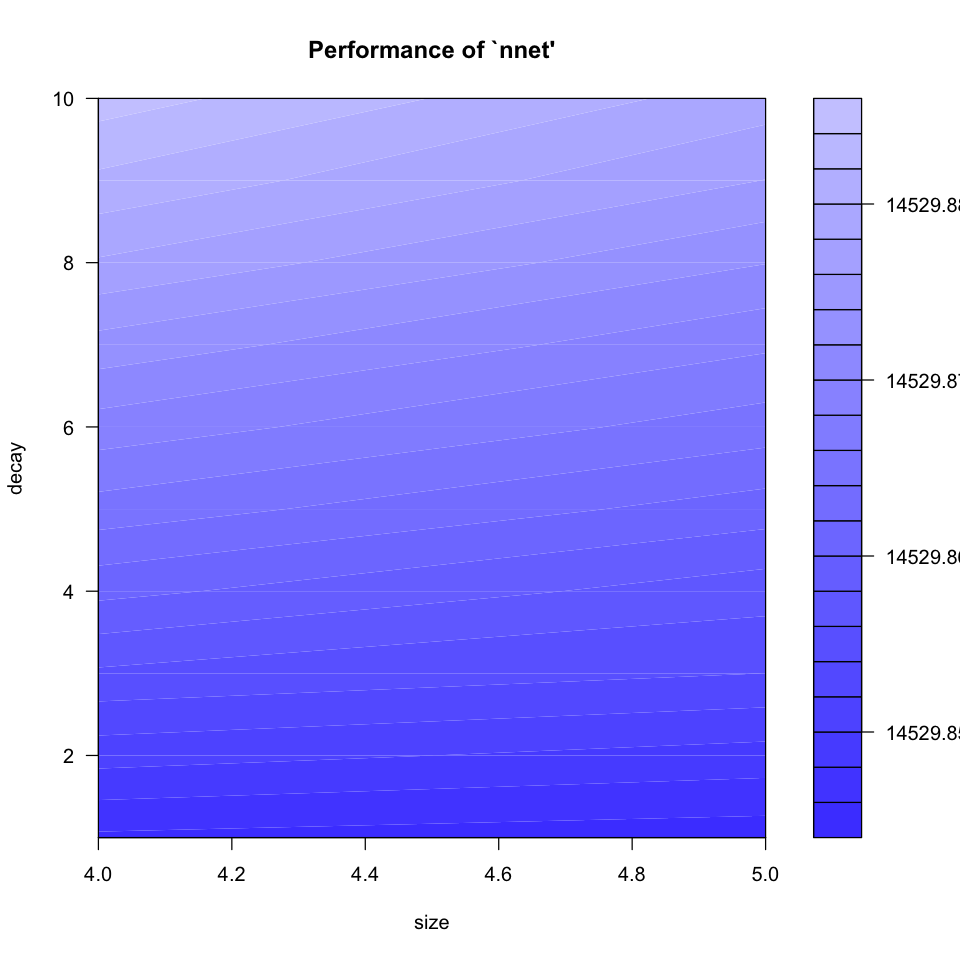

In [90]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

Faire éventuellement varier la grille des paramètres (zoom), noter la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Noter également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. 

# weights:  43
initial  value 12096847.600100 
iter  10 value 1389975.792649
iter  20 value 1343960.140517
iter  30 value 1229903.312062
iter  40 value 1120084.326984
iter  50 value 1028249.499656
iter  60 value 809948.922786
iter  70 value 745695.837783
iter  80 value 636840.279097
iter  90 value 606111.526066
iter 100 value 575206.287933
iter 110 value 560324.640768
iter 120 value 558621.497600
iter 130 value 558220.155686
iter 140 value 557297.359934
iter 150 value 556219.274791
iter 160 value 554402.838727
iter 170 value 554282.162861
iter 180 value 554274.090866
iter 190 value 554267.236124
iter 200 value 554222.776148
final  value 554222.776148 
stopped after 200 iterations


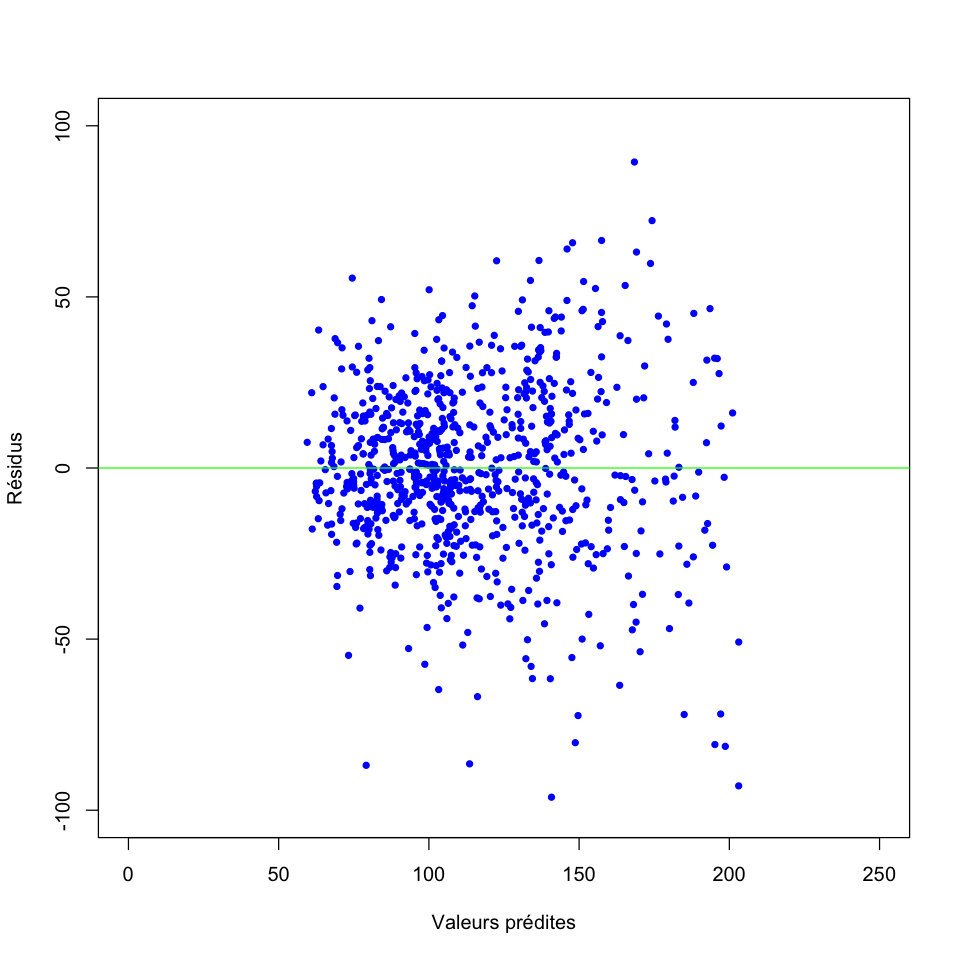

In [91]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
plot.res(fit.nnetr,res.nnetr,titre="")

### Cas de la discrimination

In [92]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

# weights:  71
initial  value 788.526760 
iter  10 value 359.033202
iter  20 value 349.809022
iter  30 value 348.231237
iter  40 value 348.223593
final  value 348.223585 
converged


a 12-3-1 network with 43 weights
options were - linear output units  decay=2
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
 -12.26    0.75   -0.01    0.33    0.93    1.49    1.98   -0.18   -0.07    0.29 
i10->h1 i11->h1 i12->h1 
  31.22    0.11    0.56 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
   2.12   -0.61    0.08    0.09   -0.60   -0.47    0.16    0.00   -0.16    0.29 
i10->h2 i11->h2 i12->h2 
 -32.92   -4.69    4.34 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
 -36.88   -4.63    0.17    0.81   -5.45   -8.14   -1.95   -2.25   -0.28   -1.02 
i10->h3 i11->h3 i12->h3 
   1.53   -4.56    0.38 
  b->o  h1->o  h2->o  h3->o 
 56.84  82.22  48.31  23.32 

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : nombre de neurones, `decay` et éventuellement le nombre max d'itérations. 

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur. 

Noter la taille et le `decay` optimaux et ré-estimer le modèle pour ces valeurs.

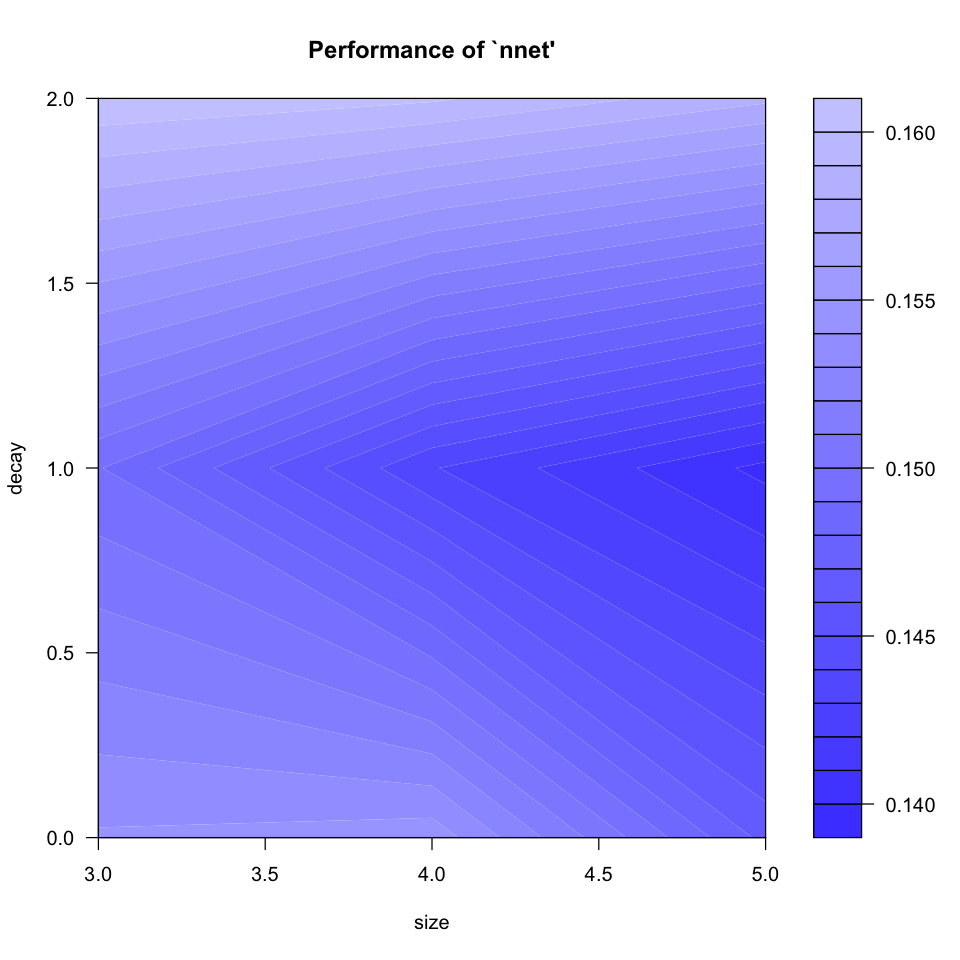

In [93]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [99]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1) 

# weights:  71
initial  value 623.679837 
iter  10 value 364.885834
iter  20 value 355.837068
iter  30 value 316.719134
iter  40 value 300.609085
iter  50 value 291.068025
iter  60 value 283.980262
iter  70 value 279.745096
iter  80 value 276.754573
iter  90 value 276.157628
iter 100 value 276.027684
final  value 276.027684 
stopped after 100 iterations


### Prévisions de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 


#### Erreur de régression

In [100]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq) 
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 629.795

#### Erreur de classification (matrice de confusion)

In [101]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   156   22
  TRUE      9   22

In [102]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])

       
        FALSE TRUE
  FALSE   163   36
  TRUE      2    8

#### Courbes ROC

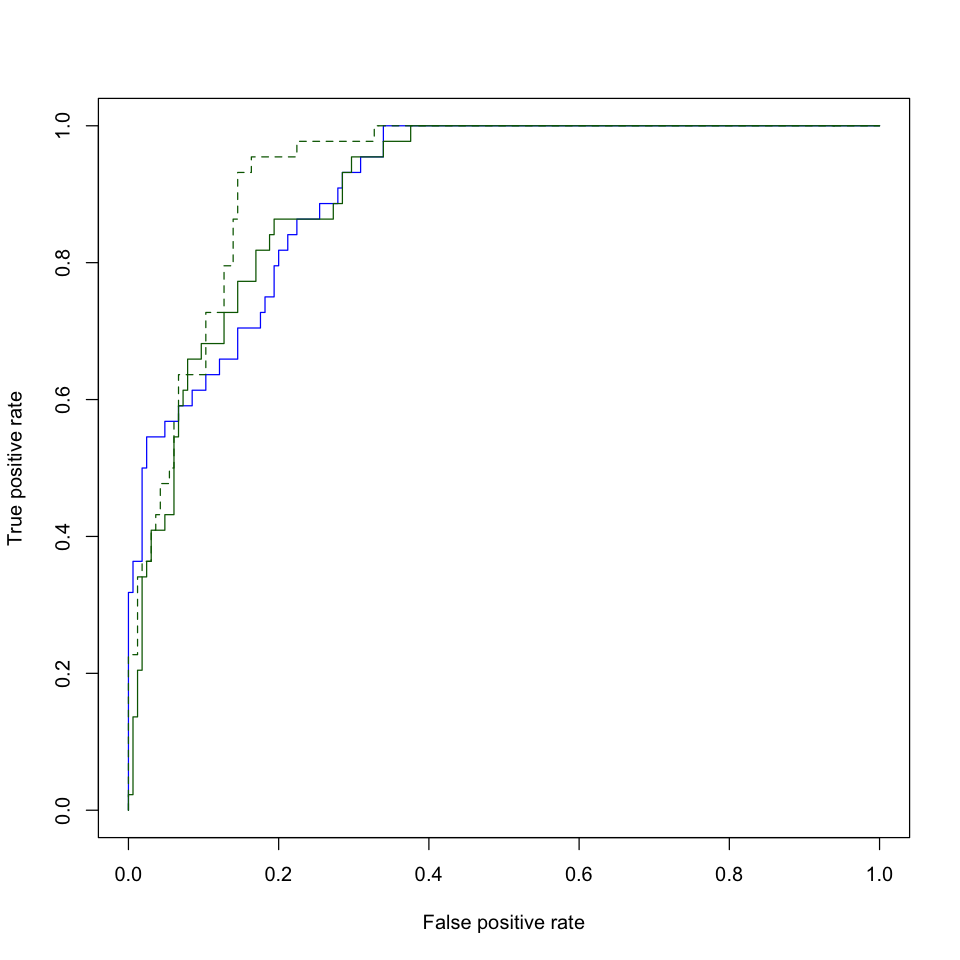

In [103]:
library(ROCR)
rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE) 
plot(perfnnetq,col="darkgreen",add=TRUE)  

**Q** Une méthode semble-t-elle significativement meilleure?

**R:** Le modèle du réseau de neuronne permet d'avoir des meilleures prédiction

## Conclusion

Le TP du Pic d'Ozone étant riche en différentes techniques de préparation et d'exploration de données, j'ai en effet appris à utiliser des librairies comme partykit, ROCR, glmnet... Tout au long du TP j'ai appliqué des modeles de regression linéaire, de Lasso, gaussien, quadratique. La regression de lasso permet de réduire le coefficient des varibles en fonction du parametre lambda. La regression gaussienne permet d'avoir une approximation de la valeur à prédir. J'ai aussi appliqué les arbres de décisions et appliquer l'élagage. Dans la partie Réseau de neurone j'ai connu les différentes fonctions d'activation tant pour la prédiction binaire ou multiclasse. En conclusion, le modèle de réseau de neurone permet d'avoir plus résultats que les autres méthodes classiques étudiées.